In [7]:
from __future__ import print_function, division
import pandas as pd
import os
# import requests
# import shapely
import numpy as np
import io
import json
import urllib
# from fiona.crs import from_epsg
import scipy as sp
from scipy import stats
# import geopy.distance
#from getCitiBikeCSV import getCitiBikeCSV # must have this function locally or in path
pd.options.display.max_columns = Nonefr
DEVELOPING = False
#from get_jsonparsed_data import get_jsonparsed_data # must have this function locally or in path
#from evalChisq import evalChisq
import queryCarto as qc
from sklearn.ensemble  import RandomForestRegressor as rfr
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
#from sklearn.ensemble  import RandomForestClassifier as rfc
from sklearn.cross_validation import train_test_split
#from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from IPython.display import Image
from IPython.display import clear_output
from sklearn.ensemble  import RandomForestClassifier as rfc
from sklearn.ensemble  import GradientBoostingClassifier as gdb
from sklearn.cross_validation import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
import sklearn.preprocessing as preprocessing
from sklearn.preprocessing import MinMaxScaler

ImportError: No module named 'sklearn.cross_validation'

In [5]:
import sklearn.metrics as skl

In [48]:
try:
    from StringIO import BytesIO as io
except ImportError:
    from io import BytesIO as io

try:
    from urllib import urlencode as urlencode
except ImportError:
    from urllib.parse import urlencode as urlencode
    
try:
    from urllib import urlopen as urlopen
except ImportError:
    from urllib.request import urlopen as urlopen
    
try:
    from urllib2 import HTTPError as HTTPError
except ImportError:
    from urllib.error import HTTPError as HTTPError

import ast

In [49]:
import geopandas as gp
import pylab as pl
import io
#import pylab as pl

from geopandas import GeoDataFrame
from geopandas.tools import sjoin
try:
    import ipywidgets as widgets
    hasWidgets = True
except ImportError:
    hasWidgets = False
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# PART I Data gathering and wrangling

## 1. Import data
The dataset can be found on NYC open data. 
The New York City Fire Department keeps a log of detailed information on incidents handled by FDNY units. In this challenge we will work with a dataset that contains a record of incidents handled by FDNY units from 2013-2017.

https://data.cityofnewyork.us/Public-Safety/Incidents-Responded-to-by-Fire-Companies/tm6d-hbzd

## 1.1 Collect School FDNY data

In [50]:
#Get puidata path
puidata = os.getenv("DATAINC")
if puidata is None:
    os.environ["DATAINC"] = "{}/DATAINC/data".format(os.getenv("HOME"))
    adsproject = os.getenv("DATAINC")
    print("Warning: DATAINC environmental variable not found and set by code, please review!")
print("DATAINC: {}".format(puidata))

PUIDATA: /Users/fbb/Dropbox//UI/PUIdata


In [51]:
def deetsdf(df,df2=None,df3=None):
    print("df1",df.shape,"\n","type",type(df),"\n","columns:",df.columns)
    if df2 != None:
        print("df2:",df2.shape,"\n","type",type(df2),"\n","columns:",df2.columns)
    if df3 != None:
        print("df3:",df3.shape,"\n","type",type(df3),"\n","columns:",df3.columns)
def deetsnp(np):
    print(df.shape,"\n","type",type(np))


In [52]:
sat = pd.read_csv('https://data.cityofnewyork.us/api/views/f9bf-2cp4/rows.csv?accessType=DOWNLOAD')
sat.head(2)

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score
0,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES,29,355,404,363
1,01M448,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,91,383,423,366


In [53]:
scores = [i for i in sat.columns.values if i != 'DBN' and i != 'SCHOOL NAME']
scores

['Num of SAT Test Takers',
 'SAT Critical Reading Avg. Score',
 'SAT Math Avg. Score',
 'SAT Writing Avg. Score']

In [54]:
sat[scores]=sat[scores].replace('s','NaN')
sat.shape

(478, 6)

In [55]:
sat.dropna(inplace=True)
schoolcrime2 =schoolcrime.drop_duplicates()

sat.shape


(478, 6)

In [56]:
type(sat['SAT Critical Reading Avg. Score'].iloc[1])

str

In [57]:
for column in scores:
    print(column)
    #print(NY_SAT[column])
    sat[column] = pd.to_numeric(sat[column].values, errors='coerce')
sat.tail(2)

Num of SAT Test Takers
SAT Critical Reading Avg. Score
SAT Math Avg. Score
SAT Writing Avg. Score


,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score
476,79Q950,GED PLUS s CITYWIDE,8.0,496.0,400.0,426.0
477,79X490,PHOENIX ACADEMY,9.0,367.0,370.0,360.0


In [58]:
deetsdf(sat)

df1 (478, 6) 
 type <class 'pandas.core.frame.DataFrame'> 
 columns: Index(['DBN', 'SCHOOL NAME', 'Num of SAT Test Takers',
       'SAT Critical Reading Avg. Score', 'SAT Math Avg. Score',
       'SAT Writing Avg. Score'],
      dtype='object')


In [59]:
sat['SATall'] = (sat['SAT Critical Reading Avg. Score']+\
                     sat['SAT Math Avg. Score']+sat['SAT Writing Avg. Score'])/3
sat.rename(columns = {'SAT Math Avg. Score': 'SATmath'}, inplace=True)
sat.head()

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SATmath,SAT Writing Avg. Score,SATall
0,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES,29.0,355.0,404.0,363.0,374.000000
1,01M448,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,91.0,383.0,423.0,366.0,390.666667
2,01M450,EAST SIDE COMMUNITY SCHOOL,70.0,377.0,402.0,370.0,383.000000
3,01M458,FORSYTH SATELLITE ACADEMY,7.0,414.0,401.0,359.0,391.333333
4,01M509,MARTA VALLE HIGH SCHOOL,44.0,390.0,433.0,384.0,402.333333


In [60]:
sat[['DBN','SATmath','SATall']].head()

,DBN,SATmath,SATall
0,01M292,404.0,374.000000
1,01M448,423.0,390.666667
2,01M450,402.0,383.000000
3,01M458,401.0,391.333333
4,01M509,433.0,402.333333


In [61]:
sat.to_csv("satScoresNYC.csv", index=False)

sat = sat[['DBN', 'SATmath', 'SATall']]
sat.to_csv("satScoresNYC.csv", index=False)
sat.head()
DBN	SATmath	SATall
0	01M292	404.0	374.000000
1	01M448	423.0	390.666667
2	01M450	402.0	383.000000
3	01M458	401.0	391.333333
4	01M509	433.0	402.333333

# FBB ok

## 1.2 Collect School Crime data (5 points)

This data collects crimes in schools from 2010 to 2016 on NYC open data.

The file is called School Safety Report

Number of crimes are reported by school and by crime category. This file contains location information (Lat/Lon for each school in the dataset) which will be the basis of your geospatial aggregations

read in the NYPD crimes in school report
inspect the distribution of crimes per school
plot the distribution of "Average number of Major" crimes by school
You need to decide which variable should be used to identify the school. Since you will later merge this with the SAT scores it makes sense to use a variable that is in both datasets.

In [62]:
schoolcrime = pd.read_csv('https://data.cityofnewyork.us/api/views/qybk-bjjc/rows.csv?accessType=DOWNLOAD')
schoolcrime.tail(1)

,School Year,Building Code,DBN,Location Name,Location Code,Address,Borough,Geographical District Code,Register,Building Name,# Schools,Schools in Building,Major N,Oth N,NoCrim N,Prop N,Vio N,ENGroupA,RangeA,AvgOfMajor N,AvgOfOth N,AvgOfNoCrim N,AvgOfProp N,AvgOfVio N,Borough Name,Postcode,Latitude,Longitude,Community Board,Council District,Census Tract,BIN,BBL,NTA
6309,2015-16,X991,79X695,Passages Academy,X695,560 BROOK AVENUE,X,7.0,254,NaN,1,Passages Academy,0.0,0.0,0.0,0.0,0.0,3C,251-500,0.27,0.9,1.67,0.63,0.44,BRONX,10455.0,40.815878,-73.914404,1.0,17.0,71.0,2000133.0,2.022760e+09,Melrose South-Mott Haven North ...


In [63]:
#Major N	Oth N	NoCrim N	Prop N	Vio N
#AvgOfMajor N	AvgOfOth N	AvgOfNoCrim N	AvgOfProp N	AvgOfVio N
crimecols = ['Major N','Oth N','NoCrim N','Prop N','Vio N', \
             'AvgOfMajor N','AvgOfOth N','AvgOfNoCrim N','AvgOfProp N','AvgOfVio N']

In [64]:
#sfig = pd.scatter_matrix(schoolcrime, s=30, figsize=(10, 10), diagonal='kde')

# FBB plots w unreadable labels are never acceptable!

#### Figure 1.2 Visualization of all the merged schools and crime dataset (plot matrix of all the columns)

In [65]:
# 'Major N'
# number of major crimes

# 'AvgOfMajor N'
# "Average of major crimes for all buildings that have the same EnGroupA/Range A"

In [66]:
len(schoolcrime['Major N'].unique())


13

Text(0, 0.5, 'Number of School Buildings')

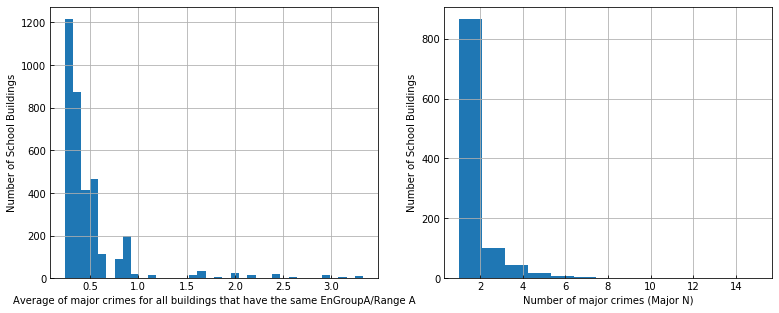

In [67]:
fig = pl.figure(figsize=(20,5))
ax = fig.add_subplot(131)
schoolcrime['AvgOfMajor N'].dropna().hist(ax=ax, bins=len(schoolcrime['AvgOfMajor N'].unique()))
ax.set_xlabel("Average of major crimes for all buildings that have the same EnGroupA/Range A")
ax.set_ylabel("Number of School Buildings")

ax = fig.add_subplot(132)
schoolcrime['Major N'][(schoolcrime['Major N']>0)].dropna().hist(ax=ax, bins=len(schoolcrime['Major N'].unique()))
ax.set_xlabel("Number of major crimes (Major N)")
ax.set_ylabel("Number of School Buildings")

# ax = fig.add_subplot(133)
# bkmerged.parkcount.hist(ax=ax)
# ax.set_xlabel("Number of Parks per PUMA")
# ax.set_ylabel("Number of PUMAs")

** Figure 1.3** Distribution of Major Crimes* and Average Major Crime per Group* per number of school buildings
Comments: it can be observed that the common number of major crimes are one per school, and averages are dominantly lower than 1.

\* Crime statistics were obtained from the following link:
https://data.cityofnewyork.us/Education/2010-2016-School-Safety-Report/qybk-bjjc

# FBB task 1 10/10

# 2. Merge school crime and SAT data (10 points)
Identify a common column and merge based on that. mind that there may be duplicates! especially if you only save the relevant columns



## 2.1 Merge the SAT and the crime in school data based on the school identifier. (4 points)

# For simplification, DBN is used for each schoo;

In [68]:
print('sat.shape',sat.shape,'schoolcrime.shape',schoolcrime.shape)

sat.shape (478, 7) schoolcrime.shape (6310, 34)


In [69]:
# Assume Schools are simplified to School DBN as defined by the DoE

In [70]:
schoolcols = crimecols+['DBN','Latitude','Longitude']
satcols = scores+['DBN']
schoolcrime2 =schoolcrime.drop_duplicates()
schoolcrime2.shape

(6309, 34)

In [71]:
satcols = [i for i in sat.columns.values if i != 'SCHOOL NAME']
schoolcrime2 = schoolcrime2[schoolcols]
sat.dropna(inplace=True)
sat2 = sat[satcols]

In [72]:
merged = sat2.merge(schoolcrime2, on='DBN', how='left')
print(merged.shape)
print(deetsdf(merged))
print('schoolcrime',schoolcrime.shape,'sat',sat.shape)
merged.head(1)

(1210, 18)
df1 (1210, 18) 
 type <class 'pandas.core.frame.DataFrame'> 
 columns: Index(['DBN', 'Num of SAT Test Takers', 'SAT Critical Reading Avg. Score',
       'SATmath', 'SAT Writing Avg. Score', 'SATall', 'Major N', 'Oth N',
       'NoCrim N', 'Prop N', 'Vio N', 'AvgOfMajor N', 'AvgOfOth N',
       'AvgOfNoCrim N', 'AvgOfProp N', 'AvgOfVio N', 'Latitude', 'Longitude'],
      dtype='object')
None
schoolcrime (6310, 34) sat (421, 7)


,DBN,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SATmath,SAT Writing Avg. Score,SATall,Major N,Oth N,NoCrim N,Prop N,Vio N,AvgOfMajor N,AvgOfOth N,AvgOfNoCrim N,AvgOfProp N,AvgOfVio N,Latitude,Longitude
0,01M292,29.0,355.0,404.0,363.0,374.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.713684,-73.986336


## 2.2 Fill in the missing data as appropriate keeping in mind that the school with no crimes are not included i the crime-in-school database, so there you can assume that there were 0 crimes, but the missing SAT scores cannot be assumed to be 0 of course. hints (4 points)


Missing values
You can use 
.fillna(values=0) 
to fill in missing values with 0. If this fills in missing SAT scores with 0 you can throw aways those rows afterwords. 
	School[ (school.SATmath > 0 ) * (school.SATall > 0 ) ]
This was thoroughly reviewed in the final review
https://github.com/fedhere/PUI2018_fb55/blob/master/finalreview/finalReview.ipynb
And in the notebook collecting all the examples of pandas manipulations https://github.com/fedhere/UInotebooks/blob/master/dataWrangling/PandasDataWrangling-Chap7.ipynb

### Check for Nans

In [73]:
deetsdf(merged)

df1 (1210, 18) 
 type <class 'pandas.core.frame.DataFrame'> 
 columns: Index(['DBN', 'Num of SAT Test Takers', 'SAT Critical Reading Avg. Score',
       'SATmath', 'SAT Writing Avg. Score', 'SATall', 'Major N', 'Oth N',
       'NoCrim N', 'Prop N', 'Vio N', 'AvgOfMajor N', 'AvgOfOth N',
       'AvgOfNoCrim N', 'AvgOfProp N', 'AvgOfVio N', 'Latitude', 'Longitude'],
      dtype='object')


In [74]:
merged[crimecols].head(2)

,Major N,Oth N,NoCrim N,Prop N,Vio N,AvgOfMajor N,AvgOfOth N,AvgOfNoCrim N,AvgOfProp N,AvgOfVio N
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [75]:
merged.isnull().sum()
len(schoolcrime['Major N'].unique())
sat.dropna(inplace=True)
schoolcrime2 =schoolcrime.drop_duplicates()


DBN                                  0
Num of SAT Test Takers               0
SAT Critical Reading Avg. Score      0
SATmath                              0
SAT Writing Avg. Score               0
SATall                               0
Major N                            857
Oth N                              857
NoCrim N                           857
Prop N                             857
Vio N                              857
AvgOfMajor N                       857
AvgOfOth N                         857
AvgOfNoCrim N                      857
AvgOfProp N                        857
AvgOfVio N                         857
Latitude                            13
Longitude                           13
dtype: int64

In [76]:
merged_fillna0 = merged.fillna(value=0) 
merged_fillna0[crimecols].shape

(1210, 10)

In [77]:
#merged.isnull().sum()
merged_fillna0.isin([0]).sum()


DBN                                   0
Num of SAT Test Takers                0
SAT Critical Reading Avg. Score       0
SATmath                               0
SAT Writing Avg. Score                0
SATall                                0
Major N                            1072
Oth N                               940
NoCrim N                            929
Prop N                              965
Vio N                              1027
AvgOfMajor N                        857
AvgOfOth N                          857
AvgOfNoCrim N                       857
AvgOfProp N                         857
AvgOfVio N                          857
Latitude                             13
Longitude                            13
dtype: int64

In [78]:
merged_fillna0.isnull().sum()

DBN                                0
Num of SAT Test Takers             0
SAT Critical Reading Avg. Score    0
SATmath                            0
SAT Writing Avg. Score             0
SATall                             0
Major N                            0
Oth N                              0
NoCrim N                           0
Prop N                             0
Vio N                              0
AvgOfMajor N                       0
AvgOfOth N                         0
AvgOfNoCrim N                      0
AvgOfProp N                        0
AvgOfVio N                         0
Latitude                           0
Longitude                          0
dtype: int64

In [79]:
merged_fillna0.shape

(1210, 18)

In [80]:
# merged_fillna0_noSAT_zeros = merged_fillna0[ (merged.SATmath > 0 ) * (merged.SATall > 0 ) ]
#merged_fillna0_noSAT_zeros.shape

In [81]:
merged_fillna0.columns

Index(['DBN', 'Num of SAT Test Takers', 'SAT Critical Reading Avg. Score',
       'SATmath', 'SAT Writing Avg. Score', 'SATall', 'Major N', 'Oth N',
       'NoCrim N', 'Prop N', 'Vio N', 'AvgOfMajor N', 'AvgOfOth N',
       'AvgOfNoCrim N', 'AvgOfProp N', 'AvgOfVio N', 'Latitude', 'Longitude'],
      dtype='object')

In [82]:
# HINT: mngrouped = mn.groupby("landuse").count().reset_index()
#merged_fillna0[['SATmath']] != 0

In [83]:
merged_f_dd = merged_fillna0.drop_duplicates()
#merged_fillna0.drop_duplicates(column = 'DBN')
merged_f_dd[(merged_fillna0[['SATmath']] != 0)].shape
#merged_f_dd.shape

(661, 18)

In [84]:
merged_f_dd.isin([0]).sum()

DBN                                  0
Num of SAT Test Takers               0
SAT Critical Reading Avg. Score      0
SATmath                              0
SAT Writing Avg. Score               0
SATall                               0
Major N                            523
Oth N                              391
NoCrim N                           380
Prop N                             416
Vio N                              478
AvgOfMajor N                       308
AvgOfOth N                         308
AvgOfNoCrim N                      308
AvgOfProp N                        308
AvgOfVio N                         308
Latitude                            13
Longitude                           13
dtype: int64

In [85]:
merged_f_dd
merged_fnan_dd_dm0 = merged_f_dd[ (merged_f_dd.SATmath > 0 ) * (merged_f_dd.SATall > 0 ) ]
merged_fnan_dd_dm0.shape

//anaconda/envs/earth-analytics-python/lib/python3.6/site-packages/pandas/core/computation/expressions.py:180: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  .format(op=op_str, alt_op=unsupported[op_str]))


(661, 18)

## 2.3 Count the individual school location: there may be multiple schools in a single building. What could be the implication of this in your analysis? hints (2 points)
Notes : remember to monitor and comment on the number of datapoints that are lost in the merge

SOLUTION you can get the solution https://serv.cusp.nyu.edu/~fbianco/finaldata2018/schoolsDF.csv (loosing 10 points)
groupby with multiple features
Multiple schools may exist in the same building. Group those schools together. To do that you can use the Lat/Lon pair: you can pass a tuple to .groupby as 
df.groupby([“var1”, “var2”])
After which you can apply the various methods, .count(), .mean(), …
See for example
https://github.com/fedhere/PUI2018_fb55/blob/master/HW5_fb55_session2/pandas_PLUTO_exercise_solution.ipynb
And 
https://github.com/fedhere/UInotebooks/blob/master/dataWrangling/PandasDataWrangling-Chap7.ipynb

In [86]:
#schoolcrime.groupby('DBN').mean()

In [87]:
# If we look at school crime dataset:

In [88]:
print("The total number of schools: ",schoolcrime.groupby('DBN').mean()['# Schools'].sum())
print("while the total number of DBN is: ",schoolcrime.groupby('DBN').count().shape[0])
print("This difference might be because ")

The total number of schools:  4385.883333333333
while the total number of DBN is:  1931
This difference might be because 


In [89]:
# If we look at school SAT dataset:
print("The total number of schools: ",sat.groupby('SCHOOL NAME').count().shape[0])
print("The total number of schools: ",sat.groupby('DBN').count().shape[0])

The total number of schools:  421
The total number of schools:  421


###### Comments on difference of DBN and number of schools:
For the School Crime dataset, we can see that there are more than one school in a same DBN.
The SAT dataset doesnt report so many schools because they are limited to High schools taking SATs, while the school crime data set includes kindergardens, elementary schoools, middle schools...

In [90]:
#merged_fnan_dd_dm0_latlon = merge(merged_fnan_dd_dm0_latlon, schoolcrime, on = 'DBN',)

In [91]:
merged_fnan_dd_dm0_latlon = merged_fnan_dd_dm0[ (merged_fnan_dd_dm0['Longitude'] !=  0) & (merged_fnan_dd_dm0['Latitude'] != 0)]
merged_fnan_dd_dm0_latlon.shape

(648, 18)

In [92]:
#merged_fnan_dd_dm0_latlon

In [93]:
# Check if repeated

In [94]:
#merged_fnan_dd_dm0_latlon.groupby(['Latitude','Longitude'],axis=1).first().shape
#merged_fnan_dd_dm0_latlon['latlon'] = merged_fnan_dd_dm0_latlon.z

In [95]:
merged_fnan_dd_dm0_latlon.sort_values('DBN',axis=0).tail()

,DBN,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SATmath,SAT Writing Avg. Score,SATall,Major N,Oth N,NoCrim N,Prop N,Vio N,AvgOfMajor N,AvgOfOth N,AvgOfNoCrim N,AvgOfProp N,AvgOfVio N,Latitude,Longitude
1202,75Q811,32.0,429.0,444.0,433.0,435.333333,0.0,1.0,1.0,1.0,0.0,0.35,1.06,1.09,0.73,0.50,40.756778,-73.729487
1204,75Q811,32.0,429.0,444.0,433.0,435.333333,0.0,0.0,1.0,0.0,0.0,0.27,0.90,1.67,0.63,0.44,40.756778,-73.729487
1206,79Q950,8.0,496.0,400.0,426.0,440.666667,0.0,0.0,0.0,0.0,0.0,1.57,7.21,14.07,5.14,2.57,40.702840,-73.808352
1205,79Q950,8.0,496.0,400.0,426.0,440.666667,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,40.702840,-73.808352
1207,79Q950,8.0,496.0,400.0,426.0,440.666667,0.0,0.0,0.0,0.0,0.0,1.13,8.47,15.33,3.80,3.07,40.702840,-73.808352


In [96]:
merged_fnan_dd_dm0_latlon.shape

(648, 18)

In [97]:
scores 

['Num of SAT Test Takers',
 'SAT Critical Reading Avg. Score',
 'SAT Math Avg. Score',
 'SAT Writing Avg. Score']

In [98]:
schoolsq2 = merged_fnan_dd_dm0_latlon.drop(['Num of SAT Test Takers',\
                                            'SAT Critical Reading Avg. Score',\
                                            'SAT Writing Avg. Score'], axis = 1)

In [99]:
deetsdf(schoolsq2)
schoolsq2.sort_values('DBN',axis=0).head()
#schoolsq2

df1 (648, 15) 
 type <class 'pandas.core.frame.DataFrame'> 
 columns: Index(['DBN', 'SATmath', 'SATall', 'Major N', 'Oth N', 'NoCrim N', 'Prop N',
       'Vio N', 'AvgOfMajor N', 'AvgOfOth N', 'AvgOfNoCrim N', 'AvgOfProp N',
       'AvgOfVio N', 'Latitude', 'Longitude'],
      dtype='object')


,DBN,SATmath,SATall,Major N,Oth N,NoCrim N,Prop N,Vio N,AvgOfMajor N,AvgOfOth N,AvgOfNoCrim N,AvgOfProp N,AvgOfVio N,Latitude,Longitude
0,01M292,404.0,374.000000,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,40.713684,-73.986336
3,01M448,423.0,390.666667,1.0,0.0,2.0,1.0,0.0,0.35,1.06,1.09,0.73,0.50,40.712399,-73.984497
4,01M448,423.0,390.666667,0.0,1.0,2.0,1.0,0.0,0.27,1.11,1.38,0.80,0.48,40.712399,-73.984497
5,01M448,423.0,390.666667,0.0,3.0,5.0,0.0,1.0,0.27,0.90,1.67,0.63,0.44,40.712399,-73.984497
6,01M450,402.0,383.000000,1.0,4.0,0.0,3.0,1.0,0.33,1.32,1.76,0.83,0.59,40.729589,-73.982555


In [100]:
schoolsq2.to_csv("schoolsDF.csv", index=False)

In [101]:
## OK!!

In [102]:
# ## Check
# check_q2 = pd.read_csv("https://serv.cusp.nyu.edu/~fbianco/finaldata2018/schoolsDF.csv ")
# #check_q2.head(2)
# deetsdf(check_q2)
# check_q2.sort_values('DBN',axis=0).head()

#COPIED FROM EXAMN HTML::::

DBN	Major N	Oth N	NoCrim N	Prop N	Vio N	AvgOfMajor N	AvgOfOth N	AvgOfNoCrim N	AvgOfProp N	AvgOfVio N	Latitude	Longitude	SATall	SATmath
0	16K393	0.0	0.0	0.0	0.0	0.0	0.00	0.00	0.00	0.00	0.00	40.692126	-73.931731	356.000000	355.0
1	02M418	0.0	0.0	0.0	0.0	0.0	0.33	1.32	1.76	0.83	0.59	40.704487	-74.011556	538.000000	553.0
2	02M418	0.0	0.0	0.0	0.0	0.0	0.31	1.12	1.82	0.79	0.51	40.704487	-74.011556	538.000000	553.0
3	02M418	0.0	0.0	0.0	0.0	0.0	0.28	1.11	1.74	0.75	0.53	40.704487	-74.011556	538.000000	553.0
4	16K594	0.0	0.0	0.0	0.0	0.0	0.00	0.00	0.00	0.00	0.00	40.680463	-73.922264	364.333333	372.0
schools.shape
(648, 15)

# FBB task 2 10/10

# 3. Visualize the school related data (10 points)
3.1 plot the Math SAT score and the average of all SAT scores (the feature you created in Task 1) as a function of two crime statistics (5 points)
make sure your data is numeric, plot SAT Math score and the average SAT score (Math, reading, writing), each one against the number of major crimes and the average number of crimes

In [103]:
schoolsq2.columns

Index(['DBN', 'SATmath', 'SATall', 'Major N', 'Oth N', 'NoCrim N', 'Prop N',
       'Vio N', 'AvgOfMajor N', 'AvgOfOth N', 'AvgOfNoCrim N', 'AvgOfProp N',
       'AvgOfVio N', 'Latitude', 'Longitude'],
      dtype='object')

In [104]:
q3plots = ['SATmath', 'SATall','Major N','AvgOfMajor N']

In [105]:
# Visualize first: pl.scatter(schoolsq2.SATmath,schoolsq2.SATall)

In [106]:
#sfig = pd.scatter_matrix(schoolsq2, s=30, figsize=(15, 15), diagonal='kde')

#### Figure 3.0 Visualization of all the merged schools and crime dataset (plot matrix of all the columns)

In [107]:
q3plots

['SATmath', 'SATall', 'Major N', 'AvgOfMajor N']

In [108]:
y_q3_1 = ['SATmath', 'SATall']
x_q3_1 = ['Major N', 'AvgOfMajor N']

1
2
2
4


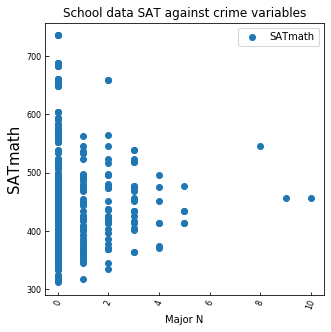

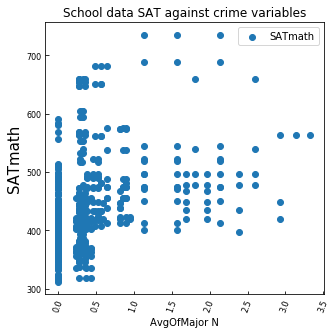

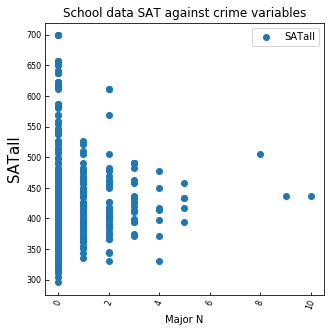

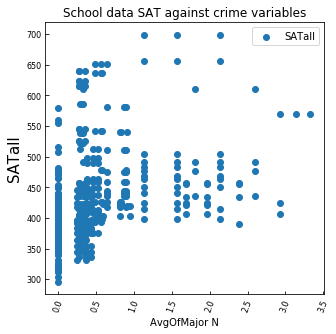

In [109]:
for j,P in enumerate(y_q3_1):
    for i,A in enumerate(x_q3_1):
        print((i+1)*(j+1))
        #ax = fig.add_subplot(4,2,(i+1)*(j+1))
        fig = pl.figure(figsize=(5,5))
        pl.title("School data SAT against crime variables")
        pl.xticks(fontsize=8)
        pl.yticks(fontsize=8)
        pl.xlabel(A)
        pl.ylabel(P,fontsize=15)
        plt.xticks(rotation=70)
        pl.scatter(schoolsq2[A], schoolsq2[P])
        #ax.plot(schoolsq2[A], schoolsq2[P], label="start")
        plt.subplots_adjust(hspace=0.5)
        pl.legend()

** Figure 3.1 ** SAT scores vs Major Crimes ('Major N') and Average of major crimes for all buildings that have the same EnGroupA/Range A ()'AvgOfMajor N')

# FBB ok, so what do these plots  tell us??

## 3.2 create geometry from the lat-lon coordinates and map the location of each school in the dataset (5 points)
hints, also reviewed in the final review

In [110]:
url = "https://data.cityofnewyork.us/api/geospatial/tqmj-j8zm?method=export&format=Shapefile"
urllib.request.urlretrieve(url, "file.gz")

('file.gz', <http.client.HTTPMessage at 0x1c269ddf60>)

In [111]:
!unzip -d $PUIDATA file.gz


Archive:  file.gz
  inflating: /Users/fbb/Dropbox//UI/PUIdata/geo_export_997a35f6-25cb-418e-be90-1b1e0749d100.dbf  
  inflating: /Users/fbb/Dropbox//UI/PUIdata/geo_export_997a35f6-25cb-418e-be90-1b1e0749d100.shp  
  inflating: /Users/fbb/Dropbox//UI/PUIdata/geo_export_997a35f6-25cb-418e-be90-1b1e0749d100.shx  
  inflating: /Users/fbb/Dropbox//UI/PUIdata/geo_export_997a35f6-25cb-418e-be90-1b1e0749d100.prj  


In [113]:
boro = gp.GeoDataFrame.from_file(os.getenv("PUIDATA") + 
                                 "/geo_export_997a35f6-25cb-418e-be90-1b1e0749d100.shp")

In [114]:
schoolsq2['lonlat'] = list(zip(schoolsq2.Longitude, schoolsq2.Latitude))


In [115]:
schoolsq2['geometry'] = schoolsq2[['lonlat']].applymap(lambda x:shapely.geometry.Point(x))


In [116]:
schoolsq2 = gp.GeoDataFrame(schoolsq2)

In [117]:
# ax = schoolsq2.plot()
# #ax = schoolsq2.plot()
# #Add axis labels:
# ax.set_xlabel("longitude (deg)", fontsize=10)
# ax.set_ylabel("latitude (deg)", fontsize=10)


Text(47.75877573593125, 0.5, 'latitude (deg)')

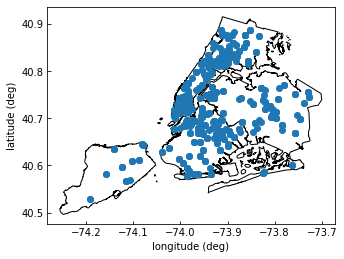

In [118]:
ax = boro.plot(facecolor="w", edgecolor="k")
schoolsq2.plot(ax=ax)
#ax.axis('off')
#add axis labels
ax.set_xlabel("longitude (deg)", fontsize=10)
ax.set_ylabel("latitude (deg)", fontsize=10)

#### Figure 3.2.2 Location of each school building in the dataset with NYC boroughs plotted for reference

\* Locations of each school buiding were obtained from the following link:
https://data.cityofnewyork.us/Education/2010-2016-School-Safety-Report/qybk-bjjc

# FBB task 3 9/10


# 4 Gather Asthma and drugs hospital discharge (10 points)
Use the SPARCS dataset which contains de-identified hospitalization data for the state of NY in 2012. This file is available at https://healthdata.ny.gov/. This is a large file and it will be time consuming to read it online or download it. Reduce the data to only the 5 NYC boroughs hint

Note: As you do all this, keep track of how many facilities are lost at each step

SHORTCUT you can download the preprocessed SPARCS data without the coordinates (https://serv.cusp.nyu.edu/~fbianco/finaldata2018/discharge.csv loosing 6 points, and you will need to perform task 4.3 by yourself) and with the coordinates (https://serv.cusp.nyu.edu/~fbianco/finaldata2018/asmaDrugsData.csv (loosing 10 points and you will still have to turn the lon-lat pairs into actual coordinate POINT objects hint)

# 4.1 read in the SPARCS data (3 points)
read in the SPARCS data
throw away the data that is not in NYC

In [119]:
# boro.to_crs(epsg=2263, inplace=True)

In [120]:
#Source: https://health.data.ny.gov/Health/Hospital-Inpatient-Discharges-SPARCS-De-Identified/u4ud-w55t

In [122]:
sparcs = pd.read_csv("../../../../../Dropbox/final2018PUI/NYSDOH_HospitalInpatientDischarges_SPARCS_De-Identified_2012.csv")
                     #https://health.data.ny.gov/api/views/u4ud-w55t/rows.csv?accessType=DOWNLOAD")

//anaconda/envs/earth-analytics-python/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [123]:
if DEVELOPING:
    s2012 = sparcs[::1000]
else:
    s2012 = sparcs
    
    

# FBB +1

In [124]:
sparcs.shape

(2544543, 38)

In [125]:
s2012.shape

(2544543, 38)

In [126]:
s2012.describe()

,Operating Certificate Number,Permanent Facility Id,Discharge Year,CCS Diagnosis Code,CCS Procedure Code,APR DRG Code,APR MDC Code,APR Severity of Illness Code,Attending Provider License Number,Operating Provider License Number,Other Provider License Number,Birth Weight,Ratio of Total Costs to Total Charges
count,2.541552e+06,2.541552e+06,2544543.0,2.544543e+06,2.544543e+06,2.544543e+06,2.544543e+06,2.544543e+06,2.541552e+06,1.911174e+06,3.525020e+05,2.544543e+06,2.544543e+06
mean,5.021701e+06,1.043650e+03,2012.0,1.919090e+02,1.145172e+02,4.107726e+02,1.026142e+01,1.998949e+00,1.506335e+06,1.727413e+06,2.479390e+06,3.151367e+02,4.291473e-01
std,2.250612e+06,6.916708e+02,0.0,1.575809e+02,8.777482e+01,2.407262e+02,5.937516e+00,9.122655e-01,9.171007e+06,9.967886e+06,1.304832e+07,9.848075e+02,5.743494e-01
min,1.010000e+05,1.000000e+00,2012.0,1.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,3.000000e+00,1.000000e+00,2.000000e+00,0.000000e+00,3.312909e-02
25%,2.951001e+06,5.410000e+02,2012.0,1.060000e+02,1.000000e+00,1.980000e+02,5.000000e+00,1.000000e+00,1.750340e+05,1.711980e+05,1.752020e+05,0.000000e+00,2.642856e-01
50%,5.907001e+06,1.122000e+03,2012.0,1.590000e+02,1.340000e+02,3.820000e+02,9.000000e+00,2.000000e+00,2.128380e+05,2.078570e+05,2.121030e+05,0.000000e+00,3.592651e-01
75%,7.002002e+06,1.450000e+03,2012.0,2.180000e+02,2.130000e+02,6.400000e+02,1.500000e+01,3.000000e+00,2.416720e+05,2.386070e+05,2.415450e+05,0.000000e+00,4.979602e-01
max,7.004010e+06,9.250000e+03,2012.0,6.700000e+02,2.310000e+02,9.560000e+02,2.500000e+01,4.000000e+00,9.100000e+07,9.100000e+07,9.100000e+07,9.900000e+03,1.752557e+02


In [127]:
s2012.head(1)

,Hospital Service Area,Hospital County,Operating Certificate Number,Permanent Facility Id,Facility Name,Age Group,Zip Code - 3 digits,Gender,Race,Ethnicity,Length of Stay,Type of Admission,Patient Disposition,Discharge Year,CCS Diagnosis Code,CCS Diagnosis Description,CCS Procedure Code,CCS Procedure Description,APR DRG Code,APR DRG Description,APR MDC Code,APR MDC Description,APR Severity of Illness Code,APR Severity of Illness Description,APR Risk of Mortality,APR Medical Surgical Description,Payment Typology 1,Payment Typology 2,Payment Typology 3,Attending Provider License Number,Operating Provider License Number,Other Provider License Number,Birth Weight,Abortion Edit Indicator,Emergency Department Indicator,Total Charges,Total Costs,Ratio of Total Costs to Total Charges
0,Western NY,Allegany,226700.0,37.0,Cuba Memorial Hospital Inc,30 to 49,147,F,White,Not Span/Hispanic,4,Elective,Home or Self Care,2012,122,Pneumonia (except that caused by tuberculosis ...,0,NO PROC,139,Other pneumonia,4,Diseases and Disorders of the Respiratory System,1,Minor,Minor,Medical,Blue Cross/Blue Shield,NaN,NaN,90301264.0,NaN,NaN,0,N,Y,"5,511.95","5,582.49",1.012798


# HINTS:

Selecting NYC facilities

The Manhattan 5 boroughs are actual counties. They are:
Manhattan, Queens, Bronx, Kings (which is the borrough of Brooklyn) and Richmond (which is the borough of Staten Island)

You can slice the array by e.g., if you wanted to extract only Brooklyn:

df[df['Hospital County'] == 'Kings'] 

Or if you wanted Brooklyn and Queens:

df[(df['Hospital County'] == 'Kings') + (df['Hospital County'] == ‘Queens’)]
or 
	df[(df['Hospital County'] == 'Kings')  |  (df['Hospital County'] == ‘Queens’)]

In [128]:
s2012nyc = s2012[(s2012['Hospital County'] == 'Richmond')+(s2012['Hospital County'] == 'Kings')\
      + (s2012['Hospital County'] == 'Queens')+(s2012['Hospital County'] == 'Manhattan')\
      + (s2012['Hospital County'] == 'Bronx')]

//anaconda/envs/earth-analytics-python/lib/python3.6/site-packages/pandas/core/computation/expressions.py:180: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  .format(op=op_str, alt_op=unsupported[op_str]))
//anaconda/envs/earth-analytics-python/lib/python3.6/site-packages/pandas/core/computation/expressions.py:180: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  .format(op=op_str, alt_op=unsupported[op_str]))
//anaconda/envs/earth-analytics-python/lib/python3.6/site-packages/pandas/core/computation/expressions.py:180: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  .format(op=op_str, alt_op=unsupported[op_str]))
//anaconda/envs/earth-analytics-python/lib/python3.6/site-packages/pandas/core/computation/expressions.py:180: UserWarning: evalua

In [129]:
# check:
print(s2012nyc['Hospital County'].unique())
deetsdf(s2012nyc)

['Bronx' 'Kings' 'Manhattan' 'Richmond' 'Queens']
df1 (1199520, 38) 
 type <class 'pandas.core.frame.DataFrame'> 
 columns: Index(['Hospital Service Area', 'Hospital County',
       'Operating Certificate Number', 'Permanent Facility Id',
       'Facility Name', 'Age Group', 'Zip Code - 3 digits', 'Gender', 'Race',
       'Ethnicity', 'Length of Stay', 'Type of Admission',
       'Patient Disposition', 'Discharge Year', 'CCS Diagnosis Code',
       'CCS Diagnosis Description', 'CCS Procedure Code',
       'CCS Procedure Description', 'APR DRG Code', 'APR DRG Description',
       'APR MDC Code', 'APR MDC Description', 'APR Severity of Illness Code',
       'APR Severity of Illness Description', 'APR Risk of Mortality',
       'APR Medical Surgical Description', 'Payment Typology 1',
       'Payment Typology 2', 'Payment Typology 3',
       'Attending Provider License Number',
       'Operating Provider License Number', 'Other Provider License Number',
       'Birth Weight', 'Abortion Ed

In [130]:
s2012nyc.head(2)

,Hospital Service Area,Hospital County,Operating Certificate Number,Permanent Facility Id,Facility Name,Age Group,Zip Code - 3 digits,Gender,Race,Ethnicity,Length of Stay,Type of Admission,Patient Disposition,Discharge Year,CCS Diagnosis Code,CCS Diagnosis Description,CCS Procedure Code,CCS Procedure Description,APR DRG Code,APR DRG Description,APR MDC Code,APR MDC Description,APR Severity of Illness Code,APR Severity of Illness Description,APR Risk of Mortality,APR Medical Surgical Description,Payment Typology 1,Payment Typology 2,Payment Typology 3,Attending Provider License Number,Operating Provider License Number,Other Provider License Number,Birth Weight,Abortion Edit Indicator,Emergency Department Indicator,Total Charges,Total Costs,Ratio of Total Costs to Total Charges
973775,New York City,Bronx,7000001.0,1164.0,Bronx-Lebanon Hospital Center - Fulton Division,18 to 29,117,M,Black/African American,Not Span/Hispanic,120 +,Emergency,Home or Self Care,2012,659,Schizophrenia and other psychotic disorders,218,PSYCHO/PSYCHI EVAL/THER,750,Schizophrenia,19,Mental Diseases and Disorders,1,Minor,Minor,Medical,Medicare,Medicaid,NaN,146195.0,146195.0,215756.0,0,N,Y,"303,147.41","298,623.82",0.985078
973776,New York City,Bronx,7000001.0,1164.0,Bronx-Lebanon Hospital Center - Fulton Division,18 to 29,104,F,Other Race,Unknown,120 +,Emergency,Home or Self Care,2012,659,Schizophrenia and other psychotic disorders,218,PSYCHO/PSYCHI EVAL/THER,750,Schizophrenia,19,Mental Diseases and Disorders,2,Moderate,Minor,Medical,Medicaid,NaN,NaN,251799.0,251799.0,NaN,0,N,N,"166,178.70","164,958.05",0.992655


## 4.2 calculate the fraction of asthma and drug related diagnoses per facility (3 points)

### count the number of asthma and drug related diagnoses per facility
### Find in the file all asthma-related diagnosis : 
### asthma and respiratory issues as diagnosis that are relevant, and 
### I used alcohol and drug related issues as well as poisoning from psychotropic substances as relevant drug-related diagnoses
### calculate the fraction of asthma/drug diagnoses over all diagnoses per facility

Selecting discharge diagnoses

This is somewhat arbitrary and if you fill like you can make a better choice go ahead. I chose the following discharge diagnoses:

'Asthma', 'Respiratory failure; insufficiency; arrest (adult)', and  'Respiratory distress syndrome' for asthma related issue, and 'Poisoning by psychotropic agents', 'Alcohol-related disorders', and  'Substance-related disorders' for drug relates issues.


The selection works the same as the selection of NYC facilities, setting  the diagnosis to be equal to one of the relevant diagnoses.

These kind of data manipulations, slicing addays by indices with boolean conditions, were reviewed in class many times and are in most of my notebooks

In [131]:
s2012nyc.columns

Index(['Hospital Service Area', 'Hospital County',
       'Operating Certificate Number', 'Permanent Facility Id',
       'Facility Name', 'Age Group', 'Zip Code - 3 digits', 'Gender', 'Race',
       'Ethnicity', 'Length of Stay', 'Type of Admission',
       'Patient Disposition', 'Discharge Year', 'CCS Diagnosis Code',
       'CCS Diagnosis Description', 'CCS Procedure Code',
       'CCS Procedure Description', 'APR DRG Code', 'APR DRG Description',
       'APR MDC Code', 'APR MDC Description', 'APR Severity of Illness Code',
       'APR Severity of Illness Description', 'APR Risk of Mortality',
       'APR Medical Surgical Description', 'Payment Typology 1',
       'Payment Typology 2', 'Payment Typology 3',
       'Attending Provider License Number',
       'Operating Provider License Number', 'Other Provider License Number',
       'Birth Weight', 'Abortion Edit Indicator',
       'Emergency Department Indicator', 'Total Charges', 'Total Costs',
       'Ratio of Total Costs to Tota

#nd = ...
#print("number of NYC discharges", nd)
######  number of NYC discharges 1199520

In [132]:
# Check if diagnosis data were all inputed 
s2012nyc.isnull().sum()

Hospital Service Area                          0
Hospital County                                0
Operating Certificate Number                   0
Permanent Facility Id                          0
Facility Name                                  0
Age Group                                      0
Zip Code - 3 digits                         1461
Gender                                         0
Race                                           0
Ethnicity                                      0
Length of Stay                                 0
Type of Admission                              0
Patient Disposition                            0
Discharge Year                                 0
CCS Diagnosis Code                             0
CCS Diagnosis Description                      0
CCS Procedure Code                             0
CCS Procedure Description                      0
APR DRG Code                                   0
APR DRG Description                            0
APR MDC Code        

In [196]:
s2012nyc.rename(columns={'Permanent Facility Id':'Facility ID'}, inplace=True)

In [197]:
nd = s2012nyc.shape
print("number of NYC discharges", nd)

number of NYC discharges (1199520, 38)


In [198]:
unique_diagostics = s2012nyc['CCS Diagnosis Description'].unique().shape
unique_diagostics

(262,)

In [199]:
nycF = s2012nyc['Facility Name'].unique().shape
print("number of NYC facilities in the dataset", nycF)

number of NYC facilities in the dataset (61,)


In [200]:
nyca_df = s2012nyc[s2012nyc['CCS Diagnosis Description'].str.contains\
         ('Asthma|Respiratory failure|insufficiency|arrest (adult)|Respiratory distress syndrome')==True]
nyca = nyca_df.shape
#s2012nyc[s2012nyc['CCS Diagnosis Description'].str.contains("asthma")]
print("number of asthma related cases in NYC", nyca[0]) 

//anaconda/envs/earth-analytics-python/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  


number of asthma related cases in NYC 30717


In [201]:
nycd_df = s2012nyc[s2012nyc['CCS Diagnosis Description'].str.contains\
         ('Poisoning by psychotropic agents|Alcohol-related disorders|Substance-related disorders')==True]
nycd = nycd_df.shape
print("number of drug related cases in NYC", nycd[0])

number of drug related cases in NYC 46336


In [202]:
nycd_df.rename(columns={'Permanent Facility Id':'Facility ID'}, inplace=True)
nyca_df.rename(columns={'Permanent Facility Id':'Facility ID'}, inplace=True)

In [203]:
nycd_red = nycd_df[['Facility ID','CCS Diagnosis Description']]
nycd_red.shape

(46336, 2)

In [204]:
nyca_red = nyca_df[['Facility ID','CCS Diagnosis Description']]
nyca_red.shape

(30717, 2)

In [205]:
nyca_grouped = nyca_red.groupby('Facility ID').count()

In [206]:
nycd_grouped = nycd_red.groupby('Facility ID').count()

In [207]:
nycd_grouped.reset_index(inplace=True)
nycd_grouped.tail(2)

,Facility ID,CCS Diagnosis Description
52,3376.0,24
53,3975.0,185


In [208]:
nyca_grouped.reset_index(inplace=True)
nyca_grouped.tail(2)

,Facility ID,CCS Diagnosis Description
53,3376.0,756
54,3975.0,397


In [209]:
nyca_grouped.head(2)

,Facility ID,CCS Diagnosis Description
0,1165.0,1123
1,1168.0,580


In [210]:
discharge_ad = pd.merge(nycd_grouped, nyca_grouped, on = 'Facility ID')

In [211]:
# CALCULATE THE TOTAL CASES PER FACILITY
sparcsALL_red = s2012nyc[['Facility ID','CCS Diagnosis Description']]
sparcsALL_red.shape

(1199520, 2)

In [212]:
sparcsALL_grouped = sparcsALL_red.groupby('Facility ID').count()
deetsdf(sparcsALL_grouped)

df1 (61, 1) 
 type <class 'pandas.core.frame.DataFrame'> 
 columns: Index(['CCS Diagnosis Description'], dtype='object')


In [213]:
sparcsALL_grouped.reset_index(inplace=True)
sparcsALL_grouped.tail(2)

,Facility ID,CCS Diagnosis Description
59,3376.0,14826
60,3975.0,12956


In [214]:
# MERGE SPARCS_ALL TO discharge_ratios

In [215]:
discharget = discharge_ad.merge(sparcsALL_grouped, on = 'Facility ID')
deetsdf(discharget)
discharget.head(2)

df1 (52, 4) 
 type <class 'pandas.core.frame.DataFrame'> 
 columns: Index(['Facility ID', 'CCS Diagnosis Description_x',
       'CCS Diagnosis Description_y', 'CCS Diagnosis Description'],
      dtype='object')


,Facility ID,CCS Diagnosis Description_x,CCS Diagnosis Description_y,CCS Diagnosis Description
0,1165.0,1279,1123,20956
1,1168.0,1006,580,15889


In [216]:
discharget.rename(columns = \
                    {'CCS Diagnosis Description_x':'drugs',\
                     'CCS Diagnosis Description_y':'asthma',\
                    'CCS Diagnosis Description':'ALL'}, inplace = True)
discharget.head(2)

,Facility ID,drugs,asthma,ALL
0,1165.0,1279,1123,20956
1,1168.0,1006,580,15889


In [217]:
discharget['asthmaRatio'] = discharget.asthma/discharget.ALL
discharget['drugsRatio'] = discharget.drugs/discharget.ALL
discharget.head()

,Facility ID,drugs,asthma,ALL,asthmaRatio,drugsRatio
0,1165.0,1279,1123,20956,0.053588,0.061033
1,1168.0,1006,580,15889,0.036503,0.063314
2,1169.0,323,2105,43650,0.048225,0.007400
3,1172.0,611,1826,23142,0.078904,0.026402
4,1176.0,4177,910,20585,0.044207,0.202915


In [218]:
deetsdf(discharget)

df1 (52, 6) 
 type <class 'pandas.core.frame.DataFrame'> 
 columns: Index(['Facility ID', 'drugs', 'asthma', 'ALL', 'asthmaRatio', 'drugsRatio'], dtype='object')


In [219]:
# Values are different to instroduction

In [220]:
discharge = discharget.loc[:,['Facility ID','asthmaRatio','drugsRatio']]

In [221]:
discharge.to_csv("discharge.csv", index=False)

In [222]:
discharge.head(2)

,Facility ID,asthmaRatio,drugsRatio
0,1165.0,0.053588,0.061033
1,1168.0,0.036503,0.063314


In [223]:
# check_q4 = pd.read_csv("https://serv.cusp.nyu.edu/~fbianco/finaldata2018/discharge.csv")
# deetsdf(check_q4)
# check_q4.sort_values("Permanent Facility Id", axis=0).head(2)

Permanent Facility Id	asthmaRatio	drugsRatio
0	1165.0	0.053588	0.036503
1	1168.0	0.036503	0.048225
2	1169.0	0.048225	0.078904
3	1172.0	0.078904	0.008216
4	1176.0	0.044207	0.044207
discharge.shape
(52, 3)

In [224]:
# OK

## 4.3 find the location of each facility (4 points)
The facility coordinate information is on my Carto account and can be accessed with a SQL query (hint)
 
count and comment on the number of facilities left after the merge

The SQL source is "https://fb55.carto.com:443/api/v2/sql?q=" and the DB name is "nyc_facilities".

You can use the script queryCarto.py


In [225]:
try:
    from StringIO import BytesIO as io
except ImportError:
    from io import BytesIO as io

try:
    from urllib import urlencode as urlencode
except ImportError:
    from urllib.parse import urlencode as urlencode
    
try:
    from urllib import urlopen as urlopen
except ImportError:
    from urllib.request import urlopen as urlopen
    
try:
    from urllib2 import HTTPError as HTTPError
except ImportError:
    from urllib.error import HTTPError as HTTPError


# FBB PEP8 violation : imports should be at the top


In [226]:
# I gave you the queryCarto script which I imported at the top
SQL_SOURCE = 'https://fb55.carto.com:443/api/v2/sql?q='

# test = '''
# SELECT *
# FROM fb55.citibike
# '''
# tmp2 = qc.get_data("SELECT  nyc_facilities, %s, %s, %s FROM fb55.acs15"%('facility_latitude',\
#                                                                                     'facility_longitude',                                                                                    keysurveyed), 
#                sql_source=SQL_SOURCE)
# tmp2.head()

In [227]:
def queryCartoDB(query, formatting = 'CSV', source = SQL_SOURCE):
    '''queries carto datasets from a given carto account
    Arguments: 
    query - string: a valid sql query string
    format - outlut format  OPTIONAL (default CSV)
    source - a valid sql api endpoint OPTIONAL (default carto fb55 account)
    Returns:
    the return of the sql query AS A STRING
    NOTES:
    designed for the carto API, tested only with CSV return format'''
    
    
    data = urlencode({'format': formatting, 'q': query}).encode("utf-8")
    try:
        response = urlopen(source, data)
        return response.read()
    except HTTPError as e:
        raise (ValueError('\n'.join(ast.literal_eval(e.readline())['error'])))
        
def get_data(query):
    try:
        return pd.read_csv(io(queryCartoDB(query)), sep = ',')
    except ValueError as v:
        print (str(v))

In [228]:
query = '''
SELECT * 
FROM nyc_facilities
'''

In [229]:
hospitallatlonSQL = get_data(query)
deetsdf(hospitallatlonSQL)

df1 (1275, 39) 
 type <class 'pandas.core.frame.DataFrame'> 
 columns: Index(['the_geom', 'regional_office', 'the_geom_webmercator', 'facility_id',
       'facility_name', 'short_description', 'description',
       'facility_open_date', 'facility_address_1', 'facility_address_2',
       'facility_city', 'facility_state', 'facility_zip_code',
       'facility_phone_number', 'facility_fax_number', 'facility_website',
       'facility_county_code', 'facility_county', 'regional_office_id',
       'cartodb_id', 'main_site_name', 'main_site_facility_id',
       'operating_certificate_number', 'operator_name', 'operator_address_1',
       'operator_address_2', 'operator_city', 'operator_state',
       'operator_zip_code', 'cooperator_name', 'cooperator_address',
       'cooperator_address_2', 'cooperator_city', 'cooperator_state',
       'cooperator_zip_code', 'ownership_type', 'facility_latitude',
       'facility_longitude', 'facility_location'],
      dtype='object')


In [230]:
hospitallatlonSQL.head(2)

,the_geom,regional_office,the_geom_webmercator,facility_id,facility_name,short_description,description,facility_open_date,facility_address_1,facility_address_2,facility_city,facility_state,facility_zip_code,facility_phone_number,facility_fax_number,facility_website,facility_county_code,facility_county,regional_office_id,cartodb_id,main_site_name,main_site_facility_id,operating_certificate_number,operator_name,operator_address_1,operator_address_2,operator_city,operator_state,operator_zip_code,cooperator_name,cooperator_address,cooperator_address_2,cooperator_city,cooperator_state,cooperator_zip_code,ownership_type,facility_latitude,facility_longitude,facility_location
0,0101000020E6100000E40F069E7B7C52C05952EE3EC753...,Metropolitan Area Regional Office - New York City,0101000020110F000046B5633099665FC167AF70FB3AED...,1320,University Hospital of Brooklyn,HOSP,Hospital,01/01/1901,445 Lenox Road,NaN,Brooklyn,New York,11203,7.182702e+09,NaN,NaN,7095,Kings,5,705,NaN,NaN,7001037H,State of New York,178-50 Linden Blvd,NaN,Jamaica,New York,11434,NaN,NaN,NaN,NaN,New York,NaN,State,40.654518,-73.945045,"(40.654518, -73.945045)"
1,0101000020E61000008BC058DFC07852C04BC8073D9B53...,Metropolitan Area Regional Office - New York City,0101000020110F00001F2C777543605FC14E668BB709ED...,6448,PALA Community Care,DTC,Diagnostic and Treatment Center,09/12/2002,1110 Pennsylvania Avenue,NaN,Brooklyn,New York,11207,7.184984e+09,NaN,NaN,7095,Kings,5,2106,NaN,NaN,7001137R,PALA Community Care LLC,1110 Pennsylvania Avenue,NaN,Brooklyn,New York,11207,NaN,NaN,NaN,NaN,New York,NaN,LLC,40.653175,-73.886772,"(40.653175, -73.886772)"


In [231]:
hospiq5 = hospitallatlonSQL.loc[:,['facility_id','facility_latitude','facility_longitude']]

In [232]:
hospiq5.tail()

,facility_id,facility_latitude,facility_longitude
1270,9853,40.594580,-73.781447
1271,9855,40.813964,-73.943913
1272,1286,40.655066,-73.912579
1273,3942,40.701995,-73.804893
1274,9173,40.745678,-73.994385


In [233]:
hospiq5.shape

(1275, 3)

In [234]:
hospiq5.rename(columns={'facility_id':'Facility_ID'}, inplace=True)
hospiq5.head(2)

,Facility_ID,facility_latitude,facility_longitude
0,1320,40.654518,-73.945045
1,6448,40.653175,-73.886772


In [235]:
hospiq5.rename(columns={'facility_latitude':'Latitude','facility_longitude':'Longitude'}, inplace=True)
deetsdf(hospiq5)
hospiq5.head(2)

df1 (1275, 3) 
 type <class 'pandas.core.frame.DataFrame'> 
 columns: Index(['Facility_ID', 'Latitude', 'Longitude'], dtype='object')


,Facility_ID,Latitude,Longitude
0,1320,40.654518,-73.945045
1,6448,40.653175,-73.886772


In [236]:
deetsdf(discharge)

df1 (52, 3) 
 type <class 'pandas.core.frame.DataFrame'> 
 columns: Index(['Facility ID', 'asthmaRatio', 'drugsRatio'], dtype='object')


In [237]:
discharge.rename(columns={'Facility ID':'Facility_ID'}, inplace=True)
discharge.head(2)

,Facility_ID,asthmaRatio,drugsRatio
0,1165.0,0.053588,0.061033
1,1168.0,0.036503,0.063314


In [238]:
discharge.to_csv("asmaDrugsData.csv", index=False)

In [239]:
hospitalsmergedq5 = hospiq5.merge(discharge,on = 'Facility_ID')
deetsdf(hospitalsmergedq5)
hospitalsmergedq5.head(2)

df1 (49, 5) 
 type <class 'pandas.core.frame.DataFrame'> 
 columns: Index(['Facility_ID', 'Latitude', 'Longitude', 'asthmaRatio', 'drugsRatio'], dtype='object')


,Facility_ID,Latitude,Longitude,asthmaRatio,drugsRatio
0,1320,40.654518,-73.945045,0.033731,0.00703
1,1445,40.814350,-73.940506,0.044740,0.09831


In [240]:
hospitalsmergedq5['lonlat'] = list(zip(hospitalsmergedq5.Longitude, hospitalsmergedq5.Latitude))
hospitalsmergedq5['geometry'] = hospitalsmergedq5[['lonlat']].applymap(lambda x:shapely.geometry.Point(x))
hospitalsmergedq5 = gp.GeoDataFrame(hospitalsmergedq5)


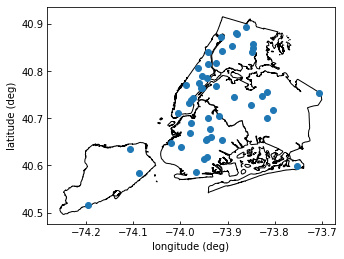

In [241]:
ax = boro.plot(facecolor="w", edgecolor="k")
ax.set_xlabel("longitude (deg)", fontsize=10)
ax.set_ylabel("latitude (deg)", fontsize=10)
hospitalsmergedq5.plot(ax=ax,label = "hospitals in NYC")
#add labels
# ax = hospitalsmergedq5.plot()

** Figure 4.3 ** Location of each hospital** in the dataset from NY SPARCS 

\** Hospital 'facility_ID' as defined by NY DOH: 
https://dev.socrata.com/foundry/health.data.ny.gov/rv8x-4fm3

# task 4 10/10


# 5. Aggregate at the PUMA level (10 points)
## 5.1 getting PUMA geodata (4 points)
You have done it many times! including in HW9 and in one of the midterms. The modeling will happen at the PUMA level, so get the PUMA data and assign to each puma a measure of sat performance, of crime, and of health

plot the PUMAs, the medical facilities, and the schools in each of the 3 datasets

 


In [242]:
url = "https://data.cityofnewyork.us/api/geospatial/cwiz-gcty?method=export&format=Shapefile"
urllib.request.urlretrieve(url, "file.gz")
!unzip -d $PUIDATA file.gz

Archive:  file.gz
  inflating: /Users/fbb/Dropbox//UI/PUIdata/geo_export_398bbc02-d699-4d91-8e6d-76b4207859fb.dbf  
  inflating: /Users/fbb/Dropbox//UI/PUIdata/geo_export_398bbc02-d699-4d91-8e6d-76b4207859fb.shp  
  inflating: /Users/fbb/Dropbox//UI/PUIdata/geo_export_398bbc02-d699-4d91-8e6d-76b4207859fb.shx  
  inflating: /Users/fbb/Dropbox//UI/PUIdata/geo_export_398bbc02-d699-4d91-8e6d-76b4207859fb.prj  


In [243]:
!unzip file.gz

Archive:  file.gz
  inflating: geo_export_398bbc02-d699-4d91-8e6d-76b4207859fb.dbf  
  inflating: geo_export_398bbc02-d699-4d91-8e6d-76b4207859fb.shp  
  inflating: geo_export_398bbc02-d699-4d91-8e6d-76b4207859fb.shx  
  inflating: geo_export_398bbc02-d699-4d91-8e6d-76b4207859fb.prj  


In [245]:
pumas = gp.GeoDataFrame.from_file(os.getenv("PUIDATA") + 
                "/geo_export_398bbc02-d699-4d91-8e6d-76b4207859fb.shp")

In [246]:
pumas.head(1)

,puma,shape_area,shape_leng,geometry
0,3701,9.792852e+07,53227.144461,POLYGON ((-73.89641133483133 40.90450452082026...


//anaconda/envs/earth-analytics-python/lib/python3.6/site-packages/geopandas/plotting.py:393: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  "'color'.", UserWarning)


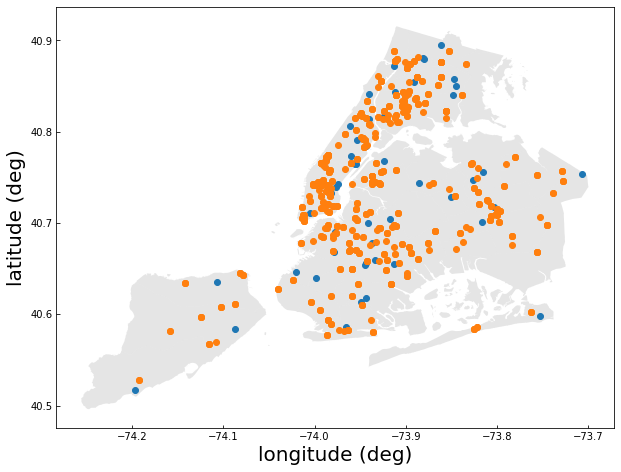

In [247]:
#leave
# Brooklyn : bk = pumas[(pumas.puma.astype(int) > 4000)]
ax = pumas.plot(column='puma', color="grey", figsize=(10,10), alpha=0.2, label =True) # edgecolor="k"
ax.set_label('s')
ax.set_xlabel("longitude (deg)", fontsize=20)
ax.set_ylabel("latitude (deg)", fontsize=20);
hospitalsmergedq5.plot(ax=ax, label=True)
schoolsq2.plot(ax=ax, label = True)


**Figure 5.1** Map of the Public Use Microarea (PUMA)* Data Census geography from 2017 together with School Buildings (DBN)** in Orange and Hospitals in Blue. 

\* PUMAs are "PUMAs are statistical geographic areas defined for the dissemination of Public Use Microdata Sample (PUMS) data. PUMAs have a minimum population of 100,000, are aggregated from census tracts, and approximate Community Districts (CDs), or combinations of CDs" - reference: NYC Open Data https://data.cityofnewyork.us/Housing-Development/Public-Use-Microdata-Areas-PUMA-/cwiz-gcty
\** School Buildings (DBN) as defined by NYC DoE: 
\*** Hospitals 'facility_ID' as defined by NY DOH: https://dev.socrata.com/foundry/health.data.ny.gov/rv8x-4fm3



# 5.2 join hospital facilities and PUMA data (3 points)
join the PUMA data with the medical facilities and school data. The resulting dataframe should have :

a puma number (which you will use to merge with the SAT and crime data)
the asthmaRatio: ratio of asthma related discharges per puma, averaged by PUMA
the drugnsRatio: ratio of asthma related discharges per puma, averaged by PUMA
This is a spatial join (hints)


In [248]:
schoolsq2.head(2)

,DBN,SATmath,SATall,Major N,Oth N,NoCrim N,Prop N,Vio N,AvgOfMajor N,AvgOfOth N,AvgOfNoCrim N,AvgOfProp N,AvgOfVio N,Latitude,Longitude,lonlat,geometry
0,01M292,404.0,374.000000,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.0,40.713684,-73.986336,"(-73.986336, 40.713684)",POINT (-73.98633599999999 40.713684)
3,01M448,423.0,390.666667,1.0,0.0,2.0,1.0,0.0,0.35,1.06,1.09,0.73,0.5,40.712399,-73.984497,"(-73.98449699999999, 40.712399)",POINT (-73.98449699999999 40.712399)


In [249]:
hospitalsmergedq5.head(2)

,Facility_ID,Latitude,Longitude,asthmaRatio,drugsRatio,lonlat,geometry
0,1320,40.654518,-73.945045,0.033731,0.00703,"(-73.945045, 40.654517999999996)",POINT (-73.94504499999999 40.654518)
1,1445,40.814350,-73.940506,0.044740,0.09831,"(-73.940506, 40.81435)",POINT (-73.940506 40.81435)


In [250]:
schoolsq2.crs = from_epsg(4326)
schoolsq2.crs

{'init': 'epsg:4326', 'no_defs': True}

In [251]:
pumas.crs = from_epsg(4326)
pumas.crs

{'init': 'epsg:4326', 'no_defs': True}

In [252]:
hospitalsmergedq5.crs = from_epsg(4326)
hospitalsmergedq5.crs

{'init': 'epsg:4326', 'no_defs': True}

In [253]:
#deetsdf(pumas,hospitalsmergedq5,schoolsq2)
print(pumas.crs)
print(hospitalsmergedq5.crs)
print(schoolsq2.crs)

{'init': 'epsg:4326', 'no_defs': True}
{'init': 'epsg:4326', 'no_defs': True}
{'init': 'epsg:4326', 'no_defs': True}


In [254]:
deetsdf(pumas)
pumas.head(5)

df1 (55, 4) 
 type <class 'geopandas.geodataframe.GeoDataFrame'> 
 columns: Index(['puma', 'shape_area', 'shape_leng', 'geometry'], dtype='object')


,puma,shape_area,shape_leng,geometry
0,3701,9.792852e+07,53227.144461,POLYGON ((-73.89641133483133 40.90450452082026...
1,3702,1.889860e+08,106050.002302,"POLYGON ((-73.8442314689986 40.86942035096838,..."
2,3703,2.670137e+08,304071.257466,(POLYGON ((-73.78833349834532 40.8346671297593...
3,3704,1.062129e+08,47970.901277,"POLYGON ((-73.84792614069238 40.8713422330779,..."
4,4015,8.105438e+07,50007.415493,POLYGON ((-73.95374853778468 40.63858633758547...


In [255]:
pumas_hospital = gp.sjoin(pumas, hospitalsmergedq5, op="contains")
print("pumas shape",pumas.shape,"decreased to pumas_hospital ", \
      pumas_hospital.shape,"; hospitalmergedq5 was ", hospitalsmergedq5.shape)

pumas shape (55, 4) decreased to pumas_hospital  (49, 11) ; hospitalmergedq5 was  (49, 7)


In [256]:
deetsdf(pumas_hospital)
phq5_2_1 = pumas_hospital[['puma','asthmaRatio','drugsRatio','geometry']]
print(phq5_2_1.shape)
#phq5_2_1.Facility_ID.unique().shape
phq5_2_1.puma.unique().shape

df1 (49, 11) 
 type <class 'geopandas.geodataframe.GeoDataFrame'> 
 columns: Index(['puma', 'shape_area', 'shape_leng', 'geometry', 'index_right',
       'Facility_ID', 'Latitude', 'Longitude', 'asthmaRatio', 'drugsRatio',
       'lonlat'],
      dtype='object')
(49, 4)


(37,)

In [257]:
phq5_2 = phq5_2_1.groupby("puma", axis= 0).mean()
phq5_2.reset_index(inplace=True)
deetsdf(phq5_2)
phq5_2.tail(2)

df1 (37, 3) 
 type <class 'pandas.core.frame.DataFrame'> 
 columns: Index(['puma', 'asthmaRatio', 'drugsRatio'], dtype='object')


,puma,asthmaRatio,drugsRatio
35,4111,0.035658,0.017224
36,4114,0.028861,0.094022



## 5.3 join school data and puma (3 points)
The resulting dataframe should have :

a puma number (which you can throw away, but you should check that it is unique in the dataframe)
the SATmath and SATall score, averaged by PUMA
10 crime related features, each averaged by PUMA
alldata.head()
puma	Major N	Oth N	NoCrim N	Prop N	Vio N	AvgOfMajor N	AvgOfOth N	AvgOfNoCrim N	AvgOfProp N	AvgOfVio N	SATmath	SATall	asthmaRatio	drugsRatio
0	3702	0.000000	0.000000	0.000000	0.000000	0.000000	0.000000	0.000000	0.000000	0.000000	0.000000	378.555556	374.740741	0.036503	0.048225
1	3704	0.000000	2.625000	1.625000	1.375000	1.000000	0.108750	0.416250	0.601250	0.282500	0.188750	417.750000	409.125000	0.037053	0.027759
2	3705	0.405405	2.162162	3.540541	0.945946	1.054054	0.123243	0.461081	0.685135	0.311351	0.212162	377.567568	372.558559	0.044207	0.044207
3	3707	0.000000	0.000000	0.000000	0.000000	0.000000	0.000000	0.000000	0.000000	0.000000	0.000000	365.000000	356.833333	0.054454	0.054454
4	3709	0.000000	0.000000	0.000000	0.000000	0.000000	0.000000	0.000000	0.000000	0.000000	0.000000	372.250000	364.111111	0.057007	0.057007
alldata.to_csv("finalDataset.csv", index=False)
SOLUTION https://serv.cusp.nyu.edu/~fbianco/finaldata2018/finalDataset.csv (loose 10 points)


In [258]:
deetsdf(schoolsq2)

df1 (648, 17) 
 type <class 'geopandas.geodataframe.GeoDataFrame'> 
 columns: Index(['DBN', 'SATmath', 'SATall', 'Major N', 'Oth N', 'NoCrim N', 'Prop N',
       'Vio N', 'AvgOfMajor N', 'AvgOfOth N', 'AvgOfNoCrim N', 'AvgOfProp N',
       'AvgOfVio N', 'Latitude', 'Longitude', 'lonlat', 'geometry'],
      dtype='object')


In [259]:
pumas_schools = gp.sjoin(pumas, schoolsq2, op="contains")
print("pumas shape",pumas.shape,"decreased to pumas_schools ", \
      pumas_schools.shape,"; hospitalmergedq5 was ", schoolsq2.shape)
deetsdf(pumas_schools)


pumas shape (55, 4) decreased to pumas_schools  (648, 21) ; hospitalmergedq5 was  (648, 17)
df1 (648, 21) 
 type <class 'geopandas.geodataframe.GeoDataFrame'> 
 columns: Index(['puma', 'shape_area', 'shape_leng', 'geometry', 'index_right', 'DBN',
       'SATmath', 'SATall', 'Major N', 'Oth N', 'NoCrim N', 'Prop N', 'Vio N',
       'AvgOfMajor N', 'AvgOfOth N', 'AvgOfNoCrim N', 'AvgOfProp N',
       'AvgOfVio N', 'Latitude', 'Longitude', 'lonlat'],
      dtype='object')


In [260]:
print(type(schoolsq2.columns))
list(schoolsq2.columns)

phq5_3_1_cols = ['puma','geometry']+list(schoolsq2.columns)
phq5_3_1_colsd = [i for i in phq5_3_1_cols if i != 'Latitude' and i != 'Longitude' and i != 'lonlat']
phq5_3_1_colsd

<class 'pandas.core.indexes.base.Index'>


['puma',
 'geometry',
 'DBN',
 'SATmath',
 'SATall',
 'Major N',
 'Oth N',
 'NoCrim N',
 'Prop N',
 'Vio N',
 'AvgOfMajor N',
 'AvgOfOth N',
 'AvgOfNoCrim N',
 'AvgOfProp N',
 'AvgOfVio N',
 'geometry']

In [261]:
phq5_3_1 = pumas_schools[phq5_3_1_colsd]
print(phq5_3_1.shape, phq5_3_1.DBN.unique().shape,phq5_3_1.puma.unique().shape)
phq5_3 = phq5_3_1.groupby("puma", axis= 0).mean()
phq5_3.reset_index(inplace=True)
phq5_3.tail(2)

(648, 16) (411,) (53,)


,puma,SATmath,SATall,Major N,Oth N,NoCrim N,Prop N,Vio N,AvgOfMajor N,AvgOfOth N,AvgOfNoCrim N,AvgOfProp N,AvgOfVio N
51,4113,417.500,409.500,0.000,0.000,0.00,0.00,0.0,0.00000,0.0000,0.00000,0.00000,0.00000
52,4114,448.875,432.375,0.125,0.125,0.25,0.25,0.0,0.29875,1.1875,2.04875,0.75875,0.55875


In [262]:
deetsdf(phq5_3)
#phq5_3.describe()
phq5_3.tail(2)

df1 (53, 13) 
 type <class 'pandas.core.frame.DataFrame'> 
 columns: Index(['puma', 'SATmath', 'SATall', 'Major N', 'Oth N', 'NoCrim N', 'Prop N',
       'Vio N', 'AvgOfMajor N', 'AvgOfOth N', 'AvgOfNoCrim N', 'AvgOfProp N',
       'AvgOfVio N'],
      dtype='object')


,puma,SATmath,SATall,Major N,Oth N,NoCrim N,Prop N,Vio N,AvgOfMajor N,AvgOfOth N,AvgOfNoCrim N,AvgOfProp N,AvgOfVio N
51,4113,417.500,409.500,0.000,0.000,0.00,0.00,0.0,0.00000,0.0000,0.00000,0.00000,0.00000
52,4114,448.875,432.375,0.125,0.125,0.25,0.25,0.0,0.29875,1.1875,2.04875,0.75875,0.55875


In [263]:
puma_sch_hosp_q5 = phq5_3.merge(phq5_2,on="puma")
deetsdf(puma_sch_hosp_q5)
puma_sch_hosp_q5.head()


df1 (36, 15) 
 type <class 'pandas.core.frame.DataFrame'> 
 columns: Index(['puma', 'SATmath', 'SATall', 'Major N', 'Oth N', 'NoCrim N', 'Prop N',
       'Vio N', 'AvgOfMajor N', 'AvgOfOth N', 'AvgOfNoCrim N', 'AvgOfProp N',
       'AvgOfVio N', 'asthmaRatio', 'drugsRatio'],
      dtype='object')


,puma,SATmath,SATall,Major N,Oth N,NoCrim N,Prop N,Vio N,AvgOfMajor N,AvgOfOth N,AvgOfNoCrim N,AvgOfProp N,AvgOfVio N,asthmaRatio,drugsRatio
0,3702,378.555556,374.740741,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.036503,0.063314
1,3704,417.750000,409.125000,0.000000,2.625000,1.625000,1.375000,1.000000,0.108750,0.416250,0.601250,0.282500,0.188750,0.037053,0.032269
2,3705,377.567568,372.558559,0.405405,2.162162,3.540541,0.945946,1.054054,0.123243,0.461081,0.685135,0.311351,0.212162,0.044207,0.202915
3,3707,365.000000,356.833333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.054454,0.013583
4,3709,372.250000,364.111111,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.057007,0.003671


In [264]:
alldata = puma_sch_hosp_q5.copy()

In [265]:
# # OK WOR
# ## Check
# check_q5 = pd.read_csv("https://serv.cusp.nyu.edu/~fbianco/finaldata2018/finalDataset.csv")
# deetsdf(check_q5)
# deetsdf(puma_sch_hosp_q5)
# check_q5

# task 5 10/10



# Extra Credit : add income data
income data comes from the 2012 5 year ACS survey which can be accessed at the PUMA level



In [266]:
### SEE END OF NOTEBOOK!

# PART II Visual and Exploratory analysis and Modeling


## 6 checking collinearity and covariance of the data (10 points)
Remember to write comments for each plot!
### 6.1 plot SAT features against each other and assess collinearity (4 points)

Text(0, 0.5, 'Average SAT Scores per PUMA (SATall)')

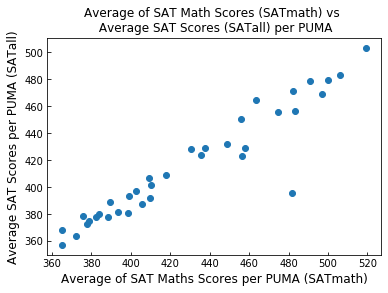

In [267]:
pl.scatter(puma_sch_hosp_q5.SATmath,puma_sch_hosp_q5.SATall)
pl.title("Average of SAT Math Scores (SATmath) vs \n Average SAT Scores (SATall) per PUMA")
pl.xlabel('Average of SAT Maths Scores per PUMA (SATmath)',fontsize=12)
pl.ylabel('Average SAT Scores per PUMA (SATall)',fontsize=12)


# Figure 6.1. Average of SAT Math Scores (SATmath) vs \n Average SAT Scores (SATall) per PUMA

In [268]:
corrmatrix_Pearson = puma_sch_hosp_q5.corr()
Pearson = corrmatrix_Pearson.iloc[0][1]
Cov_SATall_SAT_math = cov(puma_sch_hosp_q5.SATall,puma_sch_hosp_q5.SATmath)

print('Pearson product-moment correlation coefficient (PPMCC) :',Pearson)
print('Covariance is:', Cov_SATall_SAT_math[0][1])

Pearson product-moment correlation coefficient (PPMCC) : 0.9448343576745651
Covariance is: 1769.412812848337


In [269]:
puma_sch_hosp_q5[['SATall', 'SATmath']].cov()

,SATall,SATmath
SATall,1642.824517,1769.412813
SATmath,1769.412813,2134.793172


The issue with covariance is that it requires both variables to be measured on the same scale to get some meaning, i.e. covariance is not standardized and it’s interpretation is scale dependent. One cannot easily compare different covariance measurements unless the variables are all on the same scale. This is were correlation comes in.

Pearson product-moment correlation coefficient (PPMCC) or the bivariate correlation, is a measure of the linear correlation between two variables X and Y. 


As expected SATmath is correlated with SATall as SAT average all is an average from SATmath, SATreading, and SATwriting
One outlier observed where the student must have scored poorly in other sections of the SAT

In this case our variables are numeric so the Pearson correlation coefficient is a good parameter for the relationship.

# FBB ok, at this point you should identify that it is pointless to model both, cause they re very strongly collinear, and you should choose to carry on with SAT av

In [270]:
SAT_fs = ['SATmath', 'SATall']

In [271]:
H_fs = ['asthmaRatio', 'drugsRatio']

In [272]:
C_fs = [i for i in puma_sch_hosp_q5.columns if i != 'puma' and i !=H_fs[0] and i !=H_fs[1]\
                  and i != SAT_fs[0] and i != SAT_fs[0] and i != SAT_fs[1]]
C_fs

['Major N',
 'Oth N',
 'NoCrim N',
 'Prop N',
 'Vio N',
 'AvgOfMajor N',
 'AvgOfOth N',
 'AvgOfNoCrim N',
 'AvgOfProp N',
 'AvgOfVio N']

### 6.2 plot the SAT feature by PUMA against 3 of the crime features (3 points)

In [273]:
C_values = ['N number of major crimes', 'number of other crimes', 'N number of non-criminal crimes']
# Major N number of major crimes
# Oth N number of other crimes
# NoCrim N number of non-criminal crimes
C_fs
dictCrime = dict( zip( C_fs, C_values))
dictCrime['Major N']

'N number of major crimes'

In [274]:
S_values = ['Average of SAT Scores per PUMA','Average SAT Maths per PUMA']
SAT_fs
dictSAT = dict( zip( SAT_fs, S_values))
dictSAT[SAT_fs[1]]


'Average SAT Maths per PUMA'

In [275]:
# Feature sets:
# SAT_fs, H_fs, and C_fs

1
2
3
2
4
6


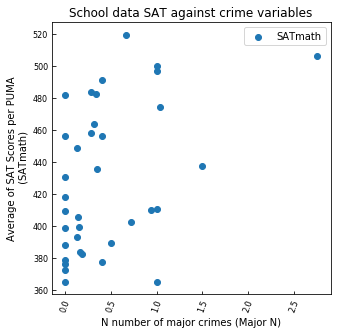

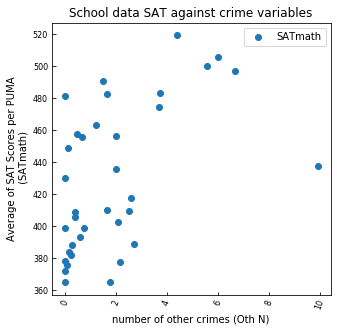

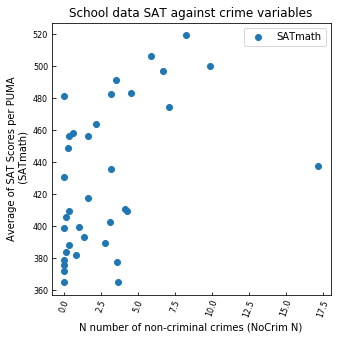

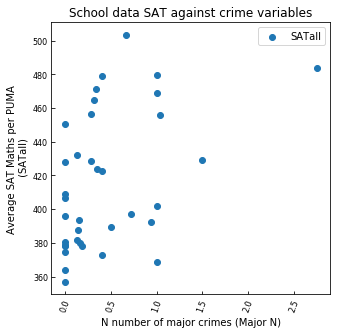

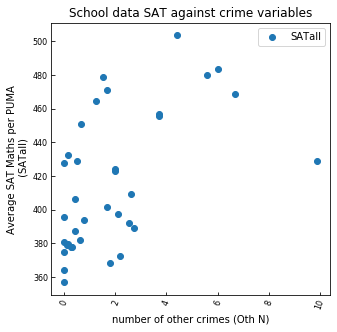

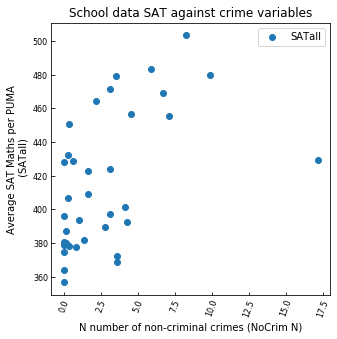

In [276]:
for j,S in enumerate(SAT_fs):
    for i,C in enumerate(C_fs[0:3]):
        print((i+1)*(j+1))
        #ax = fig.add_subplot(6,2,(i+1)*(j+1))
        fig = pl.figure(figsize=(5,5))
        pl.title("School data SAT against crime variables")
        pl.xticks(fontsize=8)
        pl.yticks(fontsize=8)
        pl.xlabel(dictCrime[C]+' ('+C+')')
        pl.ylabel(dictSAT[S]+'\n ('+S+')')
        plt.xticks(rotation=70)
        pl.scatter(puma_sch_hosp_q5[C], puma_sch_hosp_q5[S])
        #ax.plot(schoolsq2[A], schoolsq2[P], label="start")
        plt.subplots_adjust(hspace=0.5)
        pl.legend()

# FBB you just showed you dont need to plot both!

### Figure 6.2 SAT scores against Crime features 
#### Comments: Plots show interesting results: large of crimes occur occasionally at higher SAT scores but small average number of crimes occur more often at schools with low SAT scores. This could be caused because schools with higher SAT scores have more priviledged wealthier backgrounds so they receive more crimes. Or possibly higher SAT schools are under more pressure so students commit more crimes.

# FBB it would be better to plot the features together, or nearby, so as to aid comparison


### 6.3 plot the SAT feature against medical data (3 points)
Use 3 crime features and 2 medial features: asthmaRatio, drugsRatio and Major N, AvgOfNoCrim N, AvgOfMajor N. If you got income in the extra credit above also plot against income

In [277]:
puma_sch_hosp_q5.columns

Index(['puma', 'SATmath', 'SATall', 'Major N', 'Oth N', 'NoCrim N', 'Prop N',
       'Vio N', 'AvgOfMajor N', 'AvgOfOth N', 'AvgOfNoCrim N', 'AvgOfProp N',
       'AvgOfVio N', 'asthmaRatio', 'drugsRatio'],
      dtype='object')

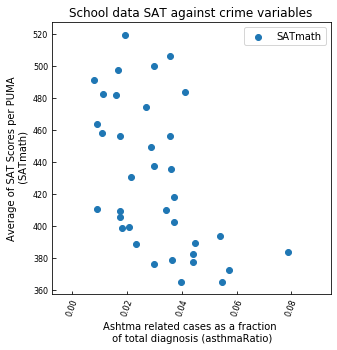

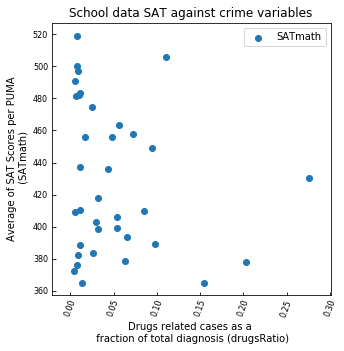

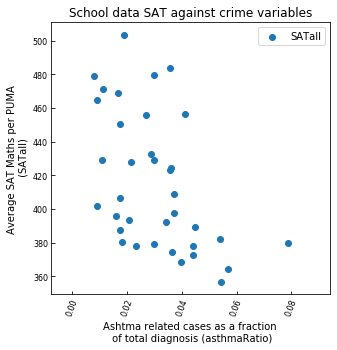

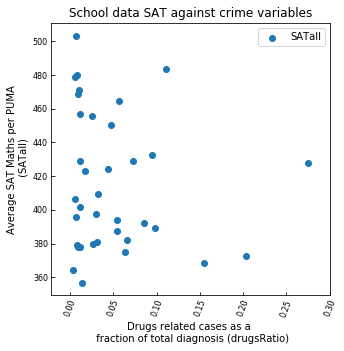

In [278]:
H_fs = ['asthmaRatio', 'drugsRatio']
# Major N number of major crimes
# Oth N number of other crimes
# NoCrim N number of non-criminal crimes
H_values = ['Ashtma related cases as a fraction \n of total diagnosis','Drugs related cases as a \n fraction of total diagnosis']
H_fs
dictHealth = dict( zip( H_fs, H_values))
dictHealth['drugsRatio']
# Feature sets:
# SAT_fs, H_fs, and C_fs
for j,S in enumerate(SAT_fs):
    for i,H in enumerate(H_fs):
        fig = pl.figure(figsize=(5,5))
        pl.title("School data SAT against crime variables")
        pl.xticks(fontsize=8)
        pl.yticks(fontsize=8)
        pl.xlabel(dictHealth[H]+' ('+H+')')
        pl.ylabel(dictSAT[S]+'\n ('+S+')')
        plt.xticks(rotation=70)
        pl.scatter(puma_sch_hosp_q5[H], puma_sch_hosp_q5[S])
        #ax.plot(schoolsq2[A], schoolsq2[P], label="start")
        plt.subplots_adjust(hspace=0.5)
        pl.legend()

### Figure 6.3 SAT scores against Health features.
#### Comments: Plots show interesting results: there seems to be a negative correlation and SAT scores

# task 6 8/10

In [279]:
puma_sch_hosp_q5.corr()

,SATmath,SATall,Major N,Oth N,NoCrim N,Prop N,Vio N,AvgOfMajor N,AvgOfOth N,AvgOfNoCrim N,AvgOfProp N,AvgOfVio N,asthmaRatio,drugsRatio
SATmath,1.000000,0.944834,0.409596,0.515652,0.463876,0.513529,0.405701,0.642957,0.637483,0.624824,0.637717,0.642784,-0.513425,-0.192345
SATall,0.944834,1.000000,0.442244,0.552993,0.516404,0.546554,0.444201,0.682967,0.666978,0.656947,0.669667,0.678993,-0.496018,-0.129519
Major N,0.409596,0.442244,1.000000,0.772296,0.713729,0.812300,0.847918,0.505400,0.473878,0.445661,0.486387,0.505710,-0.039090,0.085794
Oth N,0.515652,0.552993,0.772296,1.000000,0.942236,0.964495,0.909951,0.776359,0.753392,0.729242,0.763694,0.780618,-0.061682,-0.114821
NoCrim N,0.463876,0.516404,0.713729,0.942236,1.000000,0.870428,0.898162,0.714564,0.681103,0.662137,0.691770,0.720425,-0.099603,-0.137534
Prop N,0.513529,0.546554,0.812300,0.964495,0.870428,1.000000,0.828079,0.784886,0.764587,0.742593,0.774409,0.787975,-0.102602,-0.090692
Vio N,0.405701,0.444201,0.847918,0.909951,0.898162,0.828079,1.000000,0.582346,0.548682,0.521798,0.561731,0.585922,0.019654,-0.039707
AvgOfMajor N,0.642957,0.682967,0.505400,0.776359,0.714564,0.784886,0.582346,1.000000,0.990233,0.991419,0.990060,0.998657,-0.245228,-0.237687
AvgOfOth N,0.637483,0.666978,0.473878,0.753392,0.681103,0.764587,0.548682,0.990233,1.000000,0.989940,0.999125,0.991463,-0.239297,-0.235156
AvgOfNoCrim N,0.624824,0.656947,0.445661,0.729242,0.662137,0.742593,0.521798,0.991419,0.989940,1.000000,0.985534,0.993349,-0.236806,-0.229932


# Extra Credit: plot a covariance matrix of all features
Describe and interpret its structure

ax = pl.figure().add_subplot(111)
cax = ax.imshow(schoolcorr)
pl.colorbar(cax)
ax.set_xticks(range(len(schoolfeatures)))
ax.set_xticklabels(schoolfeatures, rotation=90)
ax.set_yticks(range(len(schoolfeatures)))
ax.set_yticklabels(schoolfeatures);

In [280]:
puma_sch_hosp_q5_corr = puma_sch_hosp_q5.drop('puma',axis=1)

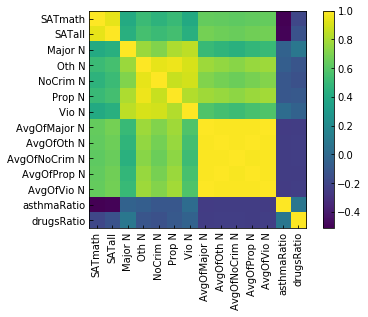

In [281]:
ax = plt.figure().add_subplot(111)
cax = ax.imshow(corrmatrix_Pearson, cmap='viridis')
plt.colorbar(cax)
ax.set_xticks(range(len(puma_sch_hosp_q5_corr.columns)))
ax.set_xticklabels(puma_sch_hosp_q5_corr.columns, rotation=90)
ax.set_yticks(range(len(puma_sch_hosp_q5_corr.columns)))
ax.set_yticklabels(puma_sch_hosp_q5_corr.columns);

# FBB no comments - no points

# 7 Mapping (10 points)
plot choropleths (maps where each area is colorcoded by the value of a variable) of

- the SAT features,

- the 3 chosen school crime features

- the two medical discharge fieatures

- the income if you have it from the extra credit

remember your visualization lecture! plot it in a way that allows comparison (hint)


7.1 
##### the SAT features

In [282]:
deetsdf(pumas_schools)
len(pumas_schools.puma.unique())

df1 (648, 21) 
 type <class 'geopandas.geodataframe.GeoDataFrame'> 
 columns: Index(['puma', 'shape_area', 'shape_leng', 'geometry', 'index_right', 'DBN',
       'SATmath', 'SATall', 'Major N', 'Oth N', 'NoCrim N', 'Prop N', 'Vio N',
       'AvgOfMajor N', 'AvgOfOth N', 'AvgOfNoCrim N', 'AvgOfProp N',
       'AvgOfVio N', 'Latitude', 'Longitude', 'lonlat'],
      dtype='object')


53

In [283]:
deetsdf(puma_sch_hosp_q5)

df1 (36, 15) 
 type <class 'pandas.core.frame.DataFrame'> 
 columns: Index(['puma', 'SATmath', 'SATall', 'Major N', 'Oth N', 'NoCrim N', 'Prop N',
       'Vio N', 'AvgOfMajor N', 'AvgOfOth N', 'AvgOfNoCrim N', 'AvgOfProp N',
       'AvgOfVio N', 'asthmaRatio', 'drugsRatio'],
      dtype='object')


In [284]:
deetsdf(pumas)
len(pumas.puma.unique())

df1 (55, 4) 
 type <class 'geopandas.geodataframe.GeoDataFrame'> 
 columns: Index(['puma', 'shape_area', 'shape_leng', 'geometry'], dtype='object')


55

In [285]:
deetsdf(pumas_schools)
len(pumas_schools.puma.unique())

df1 (648, 21) 
 type <class 'geopandas.geodataframe.GeoDataFrame'> 
 columns: Index(['puma', 'shape_area', 'shape_leng', 'geometry', 'index_right', 'DBN',
       'SATmath', 'SATall', 'Major N', 'Oth N', 'NoCrim N', 'Prop N', 'Vio N',
       'AvgOfMajor N', 'AvgOfOth N', 'AvgOfNoCrim N', 'AvgOfProp N',
       'AvgOfVio N', 'Latitude', 'Longitude', 'lonlat'],
      dtype='object')


53

In [286]:
pumasbySAT = pumas_schools[['puma','SATmath', 'SATall']]

In [287]:
pumasbySAT_grouped = pumasbySAT.groupby("puma", axis= 0).mean()
pumasbySAT_grouped.reset_index(inplace=True)
pumasbySAT_grouped.tail(2)

,puma,SATmath,SATall
51,4113,417.500,409.500
52,4114,448.875,432.375


In [288]:
puma_gp_choropleths_SAT = pumasbySAT_grouped.merge(pumas,on='puma')
print('pumasbySAT_grouped merged with pumas decreased from ',pumasbySAT_grouped.shape,\
      ' to puma_gp_choropleths',puma_gp_choropleths_SAT.shape,'\n',\
      '; also from pumas',pumas.shape,'\n')
deetsdf(puma_gp_choropleths_SAT)
puma_gp_choropleths_SAT = gp.GeoDataFrame(puma_gp_choropleths_SAT)

pumasbySAT_grouped merged with pumas decreased from  (53, 3)  to puma_gp_choropleths (53, 6) 
 ; also from pumas (55, 4) 

df1 (53, 6) 
 type <class 'pandas.core.frame.DataFrame'> 
 columns: Index(['puma', 'SATmath', 'SATall', 'shape_area', 'shape_leng', 'geometry'], dtype='object')


In [289]:
dictSAT[SAT_fs[1]]


'Average SAT Maths per PUMA'

No handles with labels found to put in legend.
No handles with labels found to put in legend.


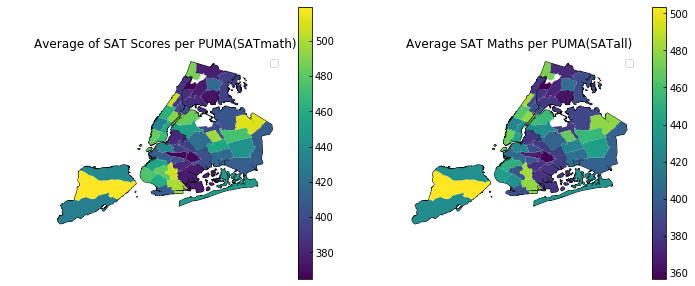

In [290]:
fig = pl.figure(figsize=(18,5))

for j,S in enumerate(SAT_fs):
    plotno = 131+ j
    ax = fig.add_subplot(plotno)
    boro.plot(ax=ax,facecolor="w", edgecolor="k")
    puma_gp_choropleths_SAT.plot(column=S, ax=ax, k=3, cmap="viridis", legend=True)
    ax.set_title(dictSAT[S]+'('+S+')')
    #ax.title('Choropleths of ',dictSAT[S],'across New York City')
    ax.set_xlabel("longitude (deg)", fontsize=10)
    ax.set_ylabel("latitude (deg)", fontsize=10)
    ax.legend()
    ax.axis('off')

**Figure 7.1 ** distribution of SATmath average per PUMA and SATall average per PUMA. 
Yellow corresponds to the highest values of each variable, blue to the lowest. Ranges are reported below. 
Both average total SAT and SATmath scores are maximal in Statten Island, and minimal in some neighbourhoods in the South of the the Bronx and Southeast Brooklyn. Note that only one neighborhood has no information probably due to an unreported area or no schools in that area.

In [291]:
print("range of SAT Average Total Score per PUMA {:.2f} {:.2f}".\
      format(puma_gp_choropleths_SAT.SATall.min(), puma_gp_choropleths_SAT.SATall.max()))
print("range of SAT Math Total Score per PUMA {:.2f} {:.2f}".\
      format(puma_gp_choropleths_SAT.SATmath.min(), puma_gp_choropleths_SAT.SATmath.max()))

range of SAT Average Total Score per PUMA 356.83 503.50
range of SAT Math Total Score per PUMA 365.00 519.33


## 7.2 the 3 chosen school crime features

In [292]:
crimecols_puma = crimecols+['puma']
crimecols_puma

['Major N',
 'Oth N',
 'NoCrim N',
 'Prop N',
 'Vio N',
 'AvgOfMajor N',
 'AvgOfOth N',
 'AvgOfNoCrim N',
 'AvgOfProp N',
 'AvgOfVio N',
 'puma']

In [293]:
deetsdf(pumas_schools)
pumasbyCRIME = pumas_schools[crimecols_puma]
pumasbyCRIME_grouped = pumasbyCRIME.groupby("puma", axis= 0).mean()
pumasbyCRIME_grouped.reset_index(inplace=True)
pumasbyCRIME_grouped.tail(2)

df1 (648, 21) 
 type <class 'geopandas.geodataframe.GeoDataFrame'> 
 columns: Index(['puma', 'shape_area', 'shape_leng', 'geometry', 'index_right', 'DBN',
       'SATmath', 'SATall', 'Major N', 'Oth N', 'NoCrim N', 'Prop N', 'Vio N',
       'AvgOfMajor N', 'AvgOfOth N', 'AvgOfNoCrim N', 'AvgOfProp N',
       'AvgOfVio N', 'Latitude', 'Longitude', 'lonlat'],
      dtype='object')


,puma,Major N,Oth N,NoCrim N,Prop N,Vio N,AvgOfMajor N,AvgOfOth N,AvgOfNoCrim N,AvgOfProp N,AvgOfVio N
51,4113,0.000,0.000,0.00,0.00,0.0,0.00000,0.0000,0.00000,0.00000,0.00000
52,4114,0.125,0.125,0.25,0.25,0.0,0.29875,1.1875,2.04875,0.75875,0.55875


In [294]:
puma_gp_choropleths_CRIME = pumasbyCRIME_grouped.merge(pumas,on='puma')
print('pumasbyCRIME_grouped merged with pumas decreased from ',pumasbyCRIME_grouped.shape,\
      ' to puma_gp_choropleths_CRIME',puma_gp_choropleths_CRIME.shape,'\n',\
      '; also from pumas',pumas.shape,'\n')
deetsdf(puma_gp_choropleths_CRIME)
puma_gp_choropleths_CRIME = gp.GeoDataFrame(puma_gp_choropleths_CRIME)

pumasbyCRIME_grouped merged with pumas decreased from  (53, 11)  to puma_gp_choropleths_CRIME (53, 14) 
 ; also from pumas (55, 4) 

df1 (53, 14) 
 type <class 'pandas.core.frame.DataFrame'> 
 columns: Index(['puma', 'Major N', 'Oth N', 'NoCrim N', 'Prop N', 'Vio N',
       'AvgOfMajor N', 'AvgOfOth N', 'AvgOfNoCrim N', 'AvgOfProp N',
       'AvgOfVio N', 'shape_area', 'shape_leng', 'geometry'],
      dtype='object')


In [295]:
C_values = ['N number of major crimes', 'number of other crimes', 'N number of non-criminal crimes',\
            'number of property crimes', 'number of violent crimes','group name that the building population falls under',\
            'average of major crimes for all buildings\n that have the same EnGroupA/Range A',\
            'average of other crimes for all buildings \n that have the same EnGroupA/Range A',\
            'average of non-criminal crimes for all buildings\n that have the same EnGroupA/Range A',\
            'average of property crimes for all buildings\n that have the same EnGroupA/Range A',\
            'average of violent crimes for all buildings \n that have the same EnGroupA/Range A']
C_fs
dictCrime = dict( zip( C_fs, C_values))
dictCrime['Major N']

'N number of major crimes'

In [296]:
dictCrime

{'Major N': 'N number of major crimes',
 'Oth N': 'number of other crimes',
 'NoCrim N': 'N number of non-criminal crimes',
 'Prop N': 'number of property crimes',
 'Vio N': 'number of violent crimes',
 'AvgOfMajor N': 'group name that the building population falls under',
 'AvgOfOth N': 'average of major crimes for all buildings\n that have the same EnGroupA/Range A',
 'AvgOfNoCrim N': 'average of other crimes for all buildings \n that have the same EnGroupA/Range A',
 'AvgOfProp N': 'average of non-criminal crimes for all buildings\n that have the same EnGroupA/Range A',
 'AvgOfVio N': 'average of property crimes for all buildings\n that have the same EnGroupA/Range A'}

0 Major N


No handles with labels found to put in legend.


1 NoCrim N


No handles with labels found to put in legend.


2 Vio N


No handles with labels found to put in legend.


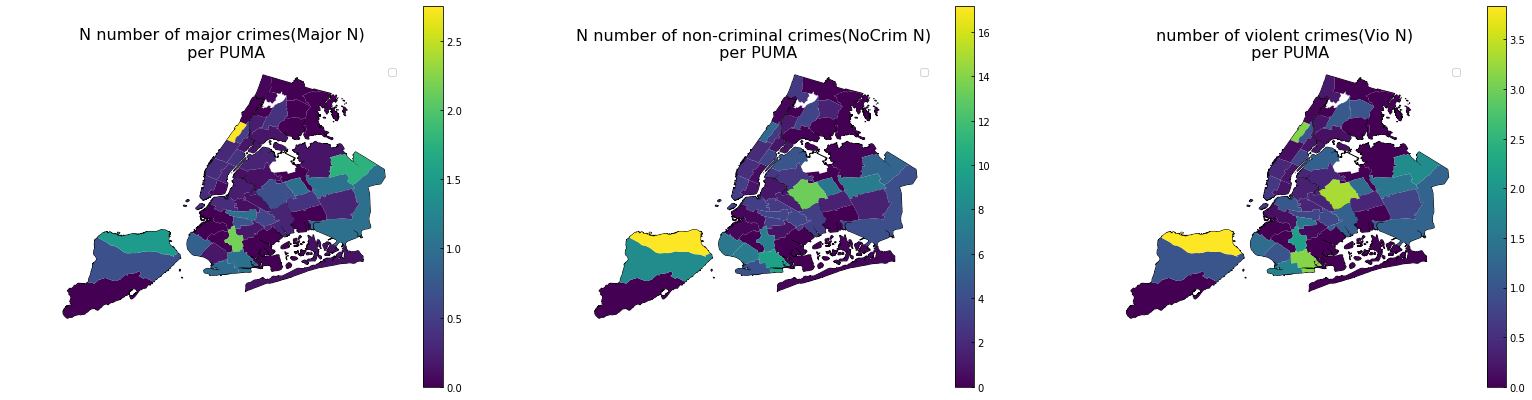

In [297]:
fig = pl.figure(figsize=(27,7))

for j,C in enumerate(C_fs[:6:2]):
    print(j,C)
    plotno = 131+ j
    ax = fig.add_subplot(plotno)
    boro.plot(ax=ax,facecolor="w", edgecolor="k")
    puma_gp_choropleths_CRIME.plot(column=C, ax=ax, k=3, cmap="viridis", legend=True)
    ax.set_title(dictCrime[C]+'('+C+') \n per PUMA', fontsize=16)
    #ax.title('Choropleths of ',dictSAT[S],'across New York City')
    ax.set_xlabel("longitude (deg)", fontsize=10)
    ax.set_ylabel("latitude (deg)", fontsize=10)
    ax.legend()
    ax.axis('off')

**Figure 7.2 ** distribution of school crimes averages per PUMA. 
Yellow corresponds to the highest values of each variable, blue to the lowest. Ranges are reported below. 
No of Major Crimes were maximal in North Manhattan, while non-criminal crimes and violent crimes were maximal in North Statten Island. In general Northern Staten Island shows high crime rates, just like Northern Manhattan and some neighborhoods in South Brooklyn and Western Queens.Note that two neighborhoods have no information probably due to an unreported or that there are no schools in that area.

In [298]:
for j,C in enumerate(C_fs[::4]):
    print('range of '+dictCrime[C]+'('+C+') per PUMA : [{:.2f} {:.2f}]'.\
      format(puma_gp_choropleths_CRIME[C].min(), puma_gp_choropleths_CRIME[C].max()))

range of N number of major crimes(Major N) per PUMA : [0.00 2.75]
range of number of violent crimes(Vio N) per PUMA : [0.00 3.83]
range of average of non-criminal crimes for all buildings
 that have the same EnGroupA/Range A(AvgOfProp N) per PUMA : [0.00 5.70]


## 7.3 the two medical discharge features


In [299]:
deetsdf(pumas_hospital)
dictHealth

df1 (49, 11) 
 type <class 'geopandas.geodataframe.GeoDataFrame'> 
 columns: Index(['puma', 'shape_area', 'shape_leng', 'geometry', 'index_right',
       'Facility_ID', 'Latitude', 'Longitude', 'asthmaRatio', 'drugsRatio',
       'lonlat'],
      dtype='object')


{'asthmaRatio': 'Ashtma related cases as a fraction \n of total diagnosis',
 'drugsRatio': 'Drugs related cases as a \n fraction of total diagnosis'}

In [300]:
puma_byHEALTH_grouped = pumas_hospital.groupby("puma", axis= 0).mean()
puma_byHEALTH_grouped.tail(2)

,shape_area,shape_leng,index_right,Facility_ID,Latitude,Longitude,asthmaRatio,drugsRatio
puma,,,,,,,,
4111,1.326029e+08,56323.365530,35.0,1629.0,40.701412,-73.816299,0.035658,0.017224
4114,3.156828e+08,412606.741739,38.0,1635.0,40.598637,-73.752769,0.028861,0.094022


In [301]:
puma_byHEALTH_grouped.reset_index(inplace=True)
#

In [302]:
puma_gp_choropleths_HEALTH = puma_byHEALTH_grouped.merge(pumas,on='puma')
print('puma_byHEALTH_grouped merged with pumas decreased from ',puma_byHEALTH_grouped.shape,\
      ' to puma_gp_choropleths_HEALTH',puma_gp_choropleths_HEALTH.shape,'\n',\
      '; also from pumas',pumas.shape,'\n')
deetsdf(puma_gp_choropleths_HEALTH)
puma_gp_choropleths_HEALTH = gp.GeoDataFrame(puma_gp_choropleths_HEALTH)
deetsdf(puma_gp_choropleths_HEALTH)

puma_byHEALTH_grouped merged with pumas decreased from  (37, 9)  to puma_gp_choropleths_HEALTH (37, 12) 
 ; also from pumas (55, 4) 

df1 (37, 12) 
 type <class 'pandas.core.frame.DataFrame'> 
 columns: Index(['puma', 'shape_area_x', 'shape_leng_x', 'index_right', 'Facility_ID',
       'Latitude', 'Longitude', 'asthmaRatio', 'drugsRatio', 'shape_area_y',
       'shape_leng_y', 'geometry'],
      dtype='object')
df1 (37, 12) 
 type <class 'geopandas.geodataframe.GeoDataFrame'> 
 columns: Index(['puma', 'shape_area_x', 'shape_leng_x', 'index_right', 'Facility_ID',
       'Latitude', 'Longitude', 'asthmaRatio', 'drugsRatio', 'shape_area_y',
       'shape_leng_y', 'geometry'],
      dtype='object')


0 asthmaRatio
1 drugsRatio


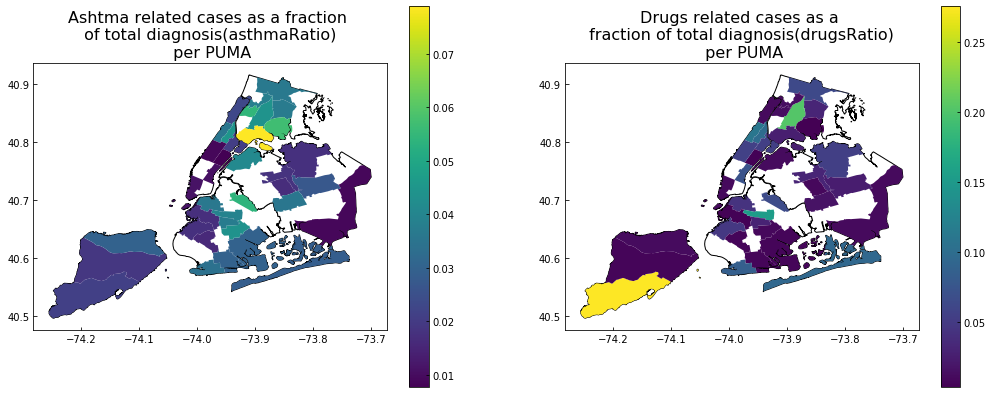

In [303]:
fig = pl.figure(figsize=(27,7))

for j,H in enumerate(H_fs):
    print(j,H)
    plotno = 131+ j
    ax = fig.add_subplot(plotno)
    boro.plot(ax=ax,facecolor="w", edgecolor="k")
    puma_gp_choropleths_HEALTH.plot(column=H, ax=ax, k=3, cmap="viridis", legend=True)
    ax.set_title(dictHealth[H]+'('+H+') \n per PUMA', fontsize=16)
    #ax.title('Choropleths of ',dictSAT[S],'across New York City')
    #ax.set_xlabel("longitude (deg)", fontsize=10)
    #ax.set_ylabel("latitude (deg)", fontsize=10)
    #ax.legend()
#    ax.axis('off')

**Figure 7.3 ** distribution of ashtma and drug diagnosis as a fraction of total diagnosis averages per PUMA. 
Yellow corresponds to the highest values, blue to the lowest. Ranges are reported below. 
Asthma ratio was maximal in South Bronx, wdrug ases were maximal in Southern Statten Island. In general the distribution of diseases is very different in both cases.

Note that only 37 out of 53 PUMAS are shown since there is no data available in the blank area (probably no hostpitals here).

# FBB again it would be better to plot the features together, or nearby, so as to aid comparison
# FBB task 7 9/10


In [304]:
for j,H in enumerate(H_fs):
    print('range of '+dictHealth[H]+'('+H+') per PUMA : [{:.2f} {:.2f}]'.\
      format(puma_gp_choropleths_HEALTH[H].min(), puma_gp_choropleths_HEALTH[H].max()))

range of Ashtma related cases as a fraction 
 of total diagnosis(asthmaRatio) per PUMA : [0.01 0.08]
range of Drugs related cases as a 
 fraction of total diagnosis(drugsRatio) per PUMA : [0.00 0.28]


## 7.4 the income if you have it from the extra credit
remember your visualization lecture! plot it in a way that allows comparison (hint)


# EXTRA CREDIT 


# 8 start with linear modeling (10 points)
#### create the models and discuss the results including pros and cons of the model choice (hint)

## 8.1 create a multivariate-linear model using only the crime in school features, but using all 10 of them, predicting the chosen SAT feature (5 points) for example with

statsmodels.formula()
hint

print and discuss the model summary



In [305]:
# CHOOSE SATall as the chosen SAT feature

In [306]:
puma_sch_hosp_q5.head(2)

,puma,SATmath,SATall,Major N,Oth N,NoCrim N,Prop N,Vio N,AvgOfMajor N,AvgOfOth N,AvgOfNoCrim N,AvgOfProp N,AvgOfVio N,asthmaRatio,drugsRatio
0,3702,378.555556,374.740741,0.0,0.000,0.000,0.000,0.0,0.00000,0.00000,0.00000,0.0000,0.00000,0.036503,0.063314
1,3704,417.750000,409.125000,0.0,2.625,1.625,1.375,1.0,0.10875,0.41625,0.60125,0.2825,0.18875,0.037053,0.032269


In [307]:
SAT_crime_cols = crimecols + ['SATall']
SAT_crime_cols

['Major N',
 'Oth N',
 'NoCrim N',
 'Prop N',
 'Vio N',
 'AvgOfMajor N',
 'AvgOfOth N',
 'AvgOfNoCrim N',
 'AvgOfProp N',
 'AvgOfVio N',
 'SATall']

In [308]:
q8_mv_reg = puma_sch_hosp_q5.loc[:,SAT_crime_cols]
q8_mv_reg.head()

,Major N,Oth N,NoCrim N,Prop N,Vio N,AvgOfMajor N,AvgOfOth N,AvgOfNoCrim N,AvgOfProp N,AvgOfVio N,SATall
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,374.740741
1,0.000000,2.625000,1.625000,1.375000,1.000000,0.108750,0.416250,0.601250,0.282500,0.188750,409.125000
2,0.405405,2.162162,3.540541,0.945946,1.054054,0.123243,0.461081,0.685135,0.311351,0.212162,372.558559
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,356.833333
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,364.111111


In [309]:
q8_mv_reg.rename(columns = {'SATall':'Y','Major N':'MajorN',\
                           'Oth N':'OthN','NoCrim N':'NoCrimN',\
                           'Prop N':'PropN','Vio N':'VioN','AvgOfMajor N':'AvgOfMajorN',\
                           'AvgOfOth N':'AvgOfOthN','AvgOfNoCrim N':'AvgOfNoCrimN',\
                           'AvgOfProp N':'AvgOfPropN','AvgOfVio N':'AvgOfVioN'}, inplace=True)

In [310]:
q8_mv_regcols = q8_mv_reg.drop('Y',axis=1).columns
len(q8_mv_regcols)

10

In [311]:
formulaq8_1='Y~'+q8_mv_regcols[0]
for i, A1 in enumerate(q8_mv_regcols[1:]):
    formulaq8_1+='+'+A1
formulaq8_1

'Y~MajorN+OthN+NoCrimN+PropN+VioN+AvgOfMajorN+AvgOfOthN+AvgOfNoCrimN+AvgOfPropN+AvgOfVioN'

In [312]:
lm8_1 = smf.ols(formula=formulaq8_1, data = q8_mv_reg).fit()
print(lm8_1.summary())

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.551
Model:                            OLS   Adj. R-squared:                  0.371
Method:                 Least Squares   F-statistic:                     3.067
Date:                Tue, 25 Dec 2018   Prob (F-statistic):             0.0111
Time:                        19:28:55   Log-Likelihood:                -169.44
No. Observations:                  36   AIC:                             360.9
Df Residuals:                      25   BIC:                             378.3
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept      383.3473     10.115     37.898   

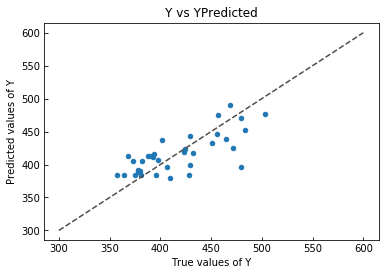

In [313]:
# Predicting the values and storing it inside a new column
q8_mv_reg.loc[:, 'Predicted_y'] = lm8_1.predict()
# Plotting the data points
q8_mv_reg.plot(x='Y',y='Predicted_y',kind='scatter',title='Y vs YPredicted')
# Plotting the predicted line
plt.plot([300, 600], [300, 600], ls="--", c=".3")
plt.xlabel("True values of Y")
plt.ylabel("Predicted values of Y")
plt.show()

** Figure 8.1 ** Multivariate regression results showing our dependent variable  Y (SAT all) and the Predicted Y

## 8.2 add drugs and asthma discharge data and create a new multilinear model (5 points)


In [314]:
SAT_crime_health_cols = crimecols + H_fs + ['SATall']
print(SAT_crime_health_cols)

['Major N', 'Oth N', 'NoCrim N', 'Prop N', 'Vio N', 'AvgOfMajor N', 'AvgOfOth N', 'AvgOfNoCrim N', 'AvgOfProp N', 'AvgOfVio N', 'asthmaRatio', 'drugsRatio', 'SATall']


In [315]:
q8_2_mv_reg = puma_sch_hosp_q5.loc[:,SAT_crime_health_cols]
q8_2_mv_reg.head(2)

,Major N,Oth N,NoCrim N,Prop N,Vio N,AvgOfMajor N,AvgOfOth N,AvgOfNoCrim N,AvgOfProp N,AvgOfVio N,asthmaRatio,drugsRatio,SATall
0,0.0,0.000,0.000,0.000,0.0,0.00000,0.00000,0.00000,0.0000,0.00000,0.036503,0.063314,374.740741
1,0.0,2.625,1.625,1.375,1.0,0.10875,0.41625,0.60125,0.2825,0.18875,0.037053,0.032269,409.125000


In [316]:
q8_2_mv_reg.rename(columns = {'SATall':'Y','Major N':'MajorN',\
                           'Oth N':'OthN','NoCrim N':'NoCrimN',\
                           'Prop N':'PropN','Vio N':'VioN','AvgOfMajor N':'AvgOfMajorN',\
                           'AvgOfOth N':'AvgOfOthN','AvgOfNoCrim N':'AvgOfNoCrimN',\
                           'AvgOfProp N':'AvgOfPropN','AvgOfVio N':'AvgOfVioN'}, inplace=True)

In [317]:
q8_2_mv_regcols = q8_2_mv_reg.drop('Y',axis=1).columns
len(q8_2_mv_regcols)

12

In [318]:
q8_2_mv_reg.head(1)

,MajorN,OthN,NoCrimN,PropN,VioN,AvgOfMajorN,AvgOfOthN,AvgOfNoCrimN,AvgOfPropN,AvgOfVioN,asthmaRatio,drugsRatio,Y
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.036503,0.063314,374.740741


In [319]:
formulaq8_2='Y~'+q8_2_mv_regcols[0]

In [320]:
for i, A1 in enumerate(q8_2_mv_regcols[1:]):
    formulaq8_2+='+'+A1
formulaq8_2

'Y~MajorN+OthN+NoCrimN+PropN+VioN+AvgOfMajorN+AvgOfOthN+AvgOfNoCrimN+AvgOfPropN+AvgOfVioN+asthmaRatio+drugsRatio'

In [321]:
lm8_2 = smf.ols(formula=formulaq8_2, data = q8_2_mv_reg).fit()
print(lm8_2.summary())

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.674
Model:                            OLS   Adj. R-squared:                  0.504
Method:                 Least Squares   F-statistic:                     3.968
Date:                Tue, 25 Dec 2018   Prob (F-statistic):            0.00222
Time:                        19:28:56   Log-Likelihood:                -163.66
No. Observations:                  36   AIC:                             353.3
Df Residuals:                      23   BIC:                             373.9
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept      418.9412     16.128     25.976   

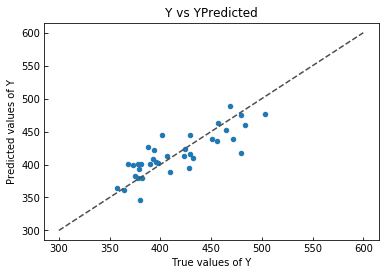

In [322]:
# Predicting the values and storing it inside a new column
q8_2_mv_reg.loc[:, 'Predicted_y'] = lm8_2.predict()
# Plotting the data points
q8_2_mv_reg.plot(x='Y',y='Predicted_y',kind='scatter',title='Y vs YPredicted')
# Plotting the predicted line
plt.plot([300, 600], [300, 600], ls="--", c=".3")
plt.xlabel("True values of Y")
plt.ylabel("Predicted values of Y")
plt.show()

** Figure 8.1 ** Multivariate regression results showing our dependent variable  Y (SAT all) and the Predicted Y

# task 8 10/10


# Extra credit: if you have income add income data and create a new multilinear model

## 9. compare the linear models (10 points):
### which is the right level of complexity? this should be a proper statistical test that returns a p-value for the null hypothesis that one model is better than the other. (hint)

Extra credit: if you did the income model, based on this result is there another multilinear model you would like to run?


if doint a linear or multilinear model

HINTS: remember to check that you have slope for all the exogenous variables in the dataset and an intercept unless you specifically wanted to force the fit through 0. Remember the OLS class and homowork!
look at he R^2 but also other statistics of goodness of fit
when comparing models remember to use metrics that account for the degrees of freedom of the model and appropriate tests for complexity (e.g. the Likelihood Ratio test)

Comparing the linear and curve fit with Likelihood Ratio LR test; we require a significance $\alpha=0.05$
The 10 features fit and 12 features fit can be compared with LR test because they are nested models

#### The difference in the number of degrees of freedom is 2, so the LR statistics will follow a $\chi^2$ distribution with 2 DOF.

In [323]:
lm8_1.llf

-169.4393524602301

In [324]:
lm8_2.llf

-163.65767893702264

In [325]:
alpha = 0.05
print ("USING LIKELIHOOD TO COMPARE MODELS, measure the likelihood ratio statistics LR : "\
       , -2 * (lm8_1.llf - (lm8_2.llf)))
print ("LR from statsmodels:", lm8_2.compare_lr_test(lm8_1))
LR = lm8_2.compare_lr_test((lm8_1))

print ("We ")
if LR[0] < 5.99: #0.05 level for 1 DOF chi sq distribution 
    print ("CANNOT") 
    
print ("reject the Null hypothesis that the 10-feature (linear) " + 
       "model is better than the 12-feature fit with p-value ")
print ("p < %.3f"%alpha)

USING LIKELIHOOD TO COMPARE MODELS, measure the likelihood ratio statistics LR :  11.563347046414947
LR from statsmodels: (11.563347046414947, 0.0030835506941596326, 2.0)
We 
reject the Null hypothesis that the 10-feature (linear) model is better than the 12-feature fit with p-value 
p < 0.050


#### COMMENTS: This result is expected as seen before in the correlation matrix. The asthma and drugs ratios shown negtive correlations with the SAT scores.

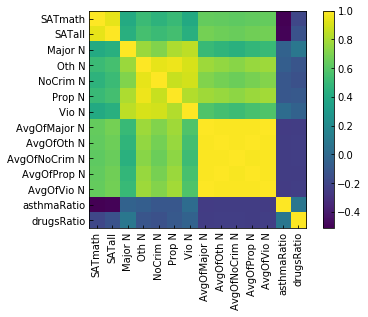

In [326]:
ax = pl.figure().add_subplot(111)
cax = ax.imshow(corrmatrix_Pearson,cmap='viridis')
pl.colorbar(cax)
ax.set_xticks(range(len(puma_sch_hosp_q5_corr.columns)))
ax.set_xticklabels(puma_sch_hosp_q5_corr.columns, rotation=90)
ax.set_yticks(range(len(puma_sch_hosp_q5_corr.columns)))
ax.set_yticklabels(puma_sch_hosp_q5_corr.columns);

# FBB its a bit more complicated than that. if the features are covariant (and contain essentially the same info) then even if they are correlated with the target variable the model may be too complex
# task 9 10/10

# 10 random forest regression on school-related data only (10 points)

Create, the models, evaluate their performance, assess the feature importance. (hint)

NOTE: do not forget to properly prepare your data for modeling!!

## 10.1 create a random forest model using only the crime in school data, but using all 10 crime in school features (5 points)
measure the model performance (hint)

In [327]:
#check_raw = pd.read_csv("https://serv.cusp.nyu.edu/~fbianco/finaldata2018/finalDataset.csv")
puma_sch_hosp_q5.tail(5)

,puma,SATmath,SATall,Major N,Oth N,NoCrim N,Prop N,Vio N,AvgOfMajor N,AvgOfOth N,AvgOfNoCrim N,AvgOfProp N,AvgOfVio N,asthmaRatio,drugsRatio
31,4106,474.392857,455.607143,1.035714,3.714286,7.107143,2.714286,1.500000,0.765714,3.323214,5.986429,2.083214,1.400357,0.026930,0.025002
32,4107,398.750000,380.666667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.018248,0.031390
33,4108,497.000000,469.000000,1.000000,6.666667,6.666667,5.333333,1.333333,1.610000,8.246667,14.633333,5.000000,3.066667,0.016690,0.009089
34,4111,456.200000,422.866667,0.400000,2.000000,1.600000,1.600000,0.400000,0.272000,1.014000,1.528000,0.662000,0.464000,0.035658,0.017224
35,4114,448.875000,432.375000,0.125000,0.125000,0.250000,0.250000,0.000000,0.298750,1.187500,2.048750,0.758750,0.558750,0.028861,0.094022


In [328]:
SAT_crime_cols = crimecols + ['SATall']
SAT_crime_cols
q10_1_rfr = puma_sch_hosp_q5.loc[:,SAT_crime_cols]
q10_1_rfr.head()
q10_1_rfr.rename(columns = {'SATall':'Y','Major N':'MajorN',\
                           'Oth N':'OthN','NoCrim N':'NoCrimN',\
                           'Prop N':'PropN','Vio N':'VioN','AvgOfMajor N':'AvgOfMajorN',\
                           'AvgOfOth N':'AvgOfOthN','AvgOfNoCrim N':'AvgOfNoCrimN',\
                           'AvgOfProp N':'AvgOfPropN','AvgOfVio N':'AvgOfVioN'}, inplace=True)
q10_1_rfr_Xcols = q10_1_rfr.drop('Y',axis=1).columns
q10_1_rfr.head()

,MajorN,OthN,NoCrimN,PropN,VioN,AvgOfMajorN,AvgOfOthN,AvgOfNoCrimN,AvgOfPropN,AvgOfVioN,Y
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,374.740741
1,0.000000,2.625000,1.625000,1.375000,1.000000,0.108750,0.416250,0.601250,0.282500,0.188750,409.125000
2,0.405405,2.162162,3.540541,0.945946,1.054054,0.123243,0.461081,0.685135,0.311351,0.212162,372.558559
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,356.833333
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,364.111111


In [329]:
q10_1_rfr_Xcols

Index(['MajorN', 'OthN', 'NoCrimN', 'PropN', 'VioN', 'AvgOfMajorN',
       'AvgOfOthN', 'AvgOfNoCrimN', 'AvgOfPropN', 'AvgOfVioN'],
      dtype='object')

In [330]:
X_crime = q10_1_rfr.loc[:,q10_1_rfr_Xcols]
X_crime.tail()

,MajorN,OthN,NoCrimN,PropN,VioN,AvgOfMajorN,AvgOfOthN,AvgOfNoCrimN,AvgOfPropN,AvgOfVioN
31,1.035714,3.714286,7.107143,2.714286,1.500000,0.765714,3.323214,5.986429,2.083214,1.400357
32,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
33,1.000000,6.666667,6.666667,5.333333,1.333333,1.610000,8.246667,14.633333,5.000000,3.066667
34,0.400000,2.000000,1.600000,1.600000,0.400000,0.272000,1.014000,1.528000,0.662000,0.464000
35,0.125000,0.125000,0.250000,0.250000,0.000000,0.298750,1.187500,2.048750,0.758750,0.558750


In [331]:
y = ravel(q10_1_rfr[['Y']])
y

array([374.74074074, 409.125     , 372.55855856, 356.83333333,
       364.11111111, 379.85964912, 378.0625    , 483.625     ,
       389.30952381, 393.69230769, 479.03333333, 464.66666667,
       428.83333333, 471.34722222, 428.        , 503.5       ,
       429.16666667, 381.91666667, 424.13043478, 406.61904762,
       368.53333333, 378.92592593, 377.96969697, 397.40740741,
       450.66666667, 395.83333333, 479.80952381, 392.28888889,
       456.66666667, 387.38095238, 401.59259259, 455.60714286,
       380.66666667, 469.        , 422.86666667, 432.375     ])

In [332]:
X_train, X_test, y_train, y_test = train_test_split(X_crime, y, test_size=0.3)
# Supervised transformation based on random forests
rf = rfr(max_depth=3, n_estimators=100, random_state=1)
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=3,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

In [333]:
y_pred = rf.predict(X_test)

In [334]:
y_pred = rf.predict(X_test)
y_pred

array([451.77004893, 451.47892079, 428.95291385, 390.15930356,
       387.66882828, 451.74171305, 383.78893434, 385.40701652,
       471.36759967, 477.56484372, 383.78893434])

In [335]:
y_pred = rf.predict(X_test)
y_pred
rf.score(X_train, y_train)

0.8650047238523748

In [336]:
rf.score(X_test, y_test)

-0.10843468965749681

In [337]:
# We could apply a seed to this problem, but then I wouldnt be able to asses the variability of the random forest
# In order to assess this high variability in the model, I will run a for loop

In [338]:
R2_train=[]
R2_test=[]
for i in range(50):
    np.random.seed(2)
    X_train, X_test, y_train, y_test = train_test_split(X_crime, y, test_size=0.3, random_state=1)
    rf = rfr(max_depth=3, n_estimators=100, random_state=1)
    rf.fit(X_train, y_train)
    rf = rfr(max_depth=3, n_estimators=100)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    R2_train.append(rf.score(X_train, y_train))
    R2_test.append(rf.score(X_test, y_test))
print("R2_train:",mean(R2_train),"\n R2_test",mean(R2_test))
#print("R2_train:",R2_train,"\n R2_test",R2_test)

R2_train: 0.8180407790173028 
 R2_test 0.034426570711454045


In [339]:
zx_1 = skl.mean_squared_error(y_test, y_pred)
zx_1

1111.0133767700158

In [340]:
R2_train=[]
R2_test=[]
for i in range(50):
    X_train, X_test, y_train, y_test = train_test_split(X_crime, y, test_size=0.3)
    rf = rfr(max_depth=3, n_estimators=100)
    rf.fit(X_train, y_train)
    rf = rfr(max_depth=3, n_estimators=100)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    R2_train.append(rf.score(X_train, y_train))
    R2_test.append(rf.score(X_test, y_test))
print("R2_train:",mean(R2_train),"\n R2_test",mean(R2_test))
#print("R2_train:",R2_train,"\n R2_test",R2_test)

R2_train: 0.8178835348363248 
 R2_test 0.2454058073612727


In [341]:
zx_1 = skl.mean_squared_error(y_test, y_pred)
zx_1

1417.6807096026778

#### Comments on results: **the model is overfitting if it performs far better on the training set than on the test set**
#### To improve, we will prepare the data better by scaling

# FBB ok, it's good to scale (unlikely to help in this case, or in general in case of overfitting with RF; whitening would be another story)

### 10.1.1 Standarize the features

** Comments on preprocessing selection of features: ** First if we standarize the Y, then we are not predicting what we should and probably the model is wouldnt perform well. R2 can be greater than 1.0 only when an invalid (or nonstandard) equation is used to compute R2 and when the chosen model (with constraints, if any) fits the data really poorly, worse than the fit of a horizontal line.

In [342]:
y = ravel(q10_1_rfr[['Y']])
y

array([374.74074074, 409.125     , 372.55855856, 356.83333333,
       364.11111111, 379.85964912, 378.0625    , 483.625     ,
       389.30952381, 393.69230769, 479.03333333, 464.66666667,
       428.83333333, 471.34722222, 428.        , 503.5       ,
       429.16666667, 381.91666667, 424.13043478, 406.61904762,
       368.53333333, 378.92592593, 377.96969697, 397.40740741,
       450.66666667, 395.83333333, 479.80952381, 392.28888889,
       456.66666667, 387.38095238, 401.59259259, 455.60714286,
       380.66666667, 469.        , 422.86666667, 432.375     ])

In [343]:
q10_1_crimeData_scaled = pd.DataFrame(columns=X_crime.columns, data=preprocessing.scale(X_crime))
q10_1_crimeData_scaled.head()

,MajorN,OthN,NoCrimN,PropN,VioN,AvgOfMajorN,AvgOfOthN,AvgOfNoCrimN,AvgOfPropN,AvgOfVioN
0,-0.785348,-0.851134,-0.794531,-0.841542,-0.808317,-0.923409,-0.810732,-0.765379,-0.852250,-0.869725
1,-0.785348,0.324183,-0.334674,0.105177,0.245558,-0.617695,-0.565271,-0.577461,-0.575915,-0.592757
2,-0.057931,0.116952,0.207403,-0.190236,0.302524,-0.576952,-0.538834,-0.551243,-0.547694,-0.558402
3,-0.785348,-0.851134,-0.794531,-0.841542,-0.808317,-0.923409,-0.810732,-0.765379,-0.852250,-0.869725
4,-0.785348,-0.851134,-0.794531,-0.841542,-0.808317,-0.923409,-0.810732,-0.765379,-0.852250,-0.869725


In [344]:
X_train, X_test, y_train, y_test = train_test_split(q10_1_crimeData_scaled, y, test_size=0.3)
# Supervised transformation based on random forests
rf_st = rfr(max_depth=3, n_estimators=100, random_state=1)
rf_st.fit(X_train, y_train)
y_pred = rf_st.predict(X_test)
rf_st.score(X_train, y_train)

0.8689986969773265

In [345]:
rf_st.score(X_test, y_test)

0.07517096001620482

In [346]:
zx = skl.mean_squared_error(y_test, y_pred)
zx

1037.1138112020196

#### Comments on results: **the model is overfitting if it performs far better on the training set than on the test set**

There seems to be a high variability in the model so we will run a for loop.

In [347]:
# To make our model reproducible:
np.random.seed(121)

In [348]:
R2_train=[]
R2_test=[]
for i in range(50):
    X_train, X_test, y_train, y_test = train_test_split(q10_1_crimeData_scaled, y, test_size=0.3)
    # Supervised transformation based on random forests
    rf_st = rfr(max_depth=3, n_estimators=100, random_state=1)
    rf_st.fit(X_train, y_train)
    y_pred = rf_st.predict(X_test)
    rf_st.score(X_train, y_train)
    rf_st = rfr(max_depth=3, n_estimators=100)
    rf_st.fit(X_train, y_train)
    y_pred = rf_st.predict(X_test)
    R2_train.append(rf_st.score(X_train, y_train))
    R2_test.append(rf_st.score(X_test, y_test))
print("R2_train:",mean(R2_train),"\n R2_test",mean(R2_test))
print("R2 train std:",np.std(R2_train))


R2_train: 0.8224077537227547 
 R2_test 0.043105545752201005
R2 train std: 0.03692657535834495


In [349]:
zx_st = skl.mean_squared_error(y_test, y_pred)

In [350]:
print("MSE:",zx_st)
#TO be discussed later

MSE: 925.8419713873435


### Comments : This still doesn't improve much the overfitting results but gives us a better understanding of a most likely results of the random forest R2.

# FBB good job!

### 10.1.2 Scale using max_min_scale

In [351]:
### Max_min_scale is the best approach to scale as the relative size of the 
#df_scaled_min_max= (df_scaled-df_scaled.min(axis=0))/(df_scaled.max(axis=0)-df_scaled.min(axis=0))

# FBB as the relative size of the...?

In [352]:
y = ravel(q10_1_rfr[['Y']])
#df_scaled.head(2)

In [353]:
# This scale
min_max_scaler = MinMaxScaler()
X_crime_max_min = pd.DataFrame(min_max_scaler.fit_transform(X_crime), columns=X_crime.columns, index=X_crime.index)
print(X_crime_max_min.shape)
X_crime_max_min.head(2)

(36, 10)


,MajorN,OthN,NoCrimN,PropN,VioN,AvgOfMajorN,AvgOfOthN,AvgOfNoCrimN,AvgOfPropN,AvgOfVioN
0,0.0,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.0000,0.000000
1,0.0,0.264706,0.09466,0.229167,0.26087,0.067547,0.050475,0.041088,0.0565,0.061549


In [354]:
X_train, X_test, y_train, y_test = train_test_split(X_crime_max_min, y, test_size=0.3)
rf_min_max = rfr(max_depth=3, n_estimators=100)
rf_min_max.fit(X_train, y_train)
y_pred = rf_min_max.predict(X_test)

In [355]:
rf_min_max.score(X_train, y_train)

0.8785503446709402

In [356]:
rf_min_max.score(X_test, y_test)

0.10326581825713277

In [357]:
# Since the variability of R2 is very high, I run the random forest many times and get an average R^2

In [358]:
R2_train=[]
R2_test=[]
for i in range(50):
    X_train, X_test, y_train, y_test = train_test_split(X_crime_max_min, y, test_size=0.3)
    rf_min_max = rfr(max_depth=3, n_estimators=100)
    rf_min_max.fit(X_train, y_train)
    y_pred = rf_min_max.predict(X_test)
    rf_min_max = rfr(max_depth=3, n_estimators=100)
    rf_min_max.fit(X_train, y_train)
    y_pred = rf_min_max.predict(X_test)
    R2_train.append(rf_min_max.score(X_train, y_train))
    R2_test.append(rf_min_max.score(X_test, y_test))
print("R2_train:",mean(R2_train),"\n R2_test",mean(R2_test))

R2_train: 0.8375378298197225 
 R2_test 0.10319749942814399


In [359]:
zx_scaled = skl.mean_squared_error(y_test, y_pred)
print("MSE:",zx_scaled)

MSE: 1648.8349457385148


** Comments on results: ** the model is not very satisfactory as train data perfroms much better than test data. In this case we have the highest R2 test for the min_max scaling method. However in general, the standarization is prefered since min_max has the downside that because we have now bounded the range from 0 to 1, we will have lower standard deviations and it suppresses the effect of outliers.

In [360]:
print("Compared to other models in question 10, our mean standard error MSE changed from ",'%.2f'%zx,\
      "in not scaled model,",'%.2f'%zx_st,\
      "in standarized model and ",'%.2f'%zx_scaled,'in min-max model')

Compared to other models in question 10, our mean standard error MSE changed from  1037.11 in not scaled model, 925.84 in standarized model and  1648.83 in min-max model


This shows that when we scale we gain in R2 but we get larger errors.


## 10.2 measure the feature importance of the features in this model to select the 3 most predictive features (5 points). You can use the code featureImportancePlotter.py if you want to visualize feature importance


In [361]:
## Feature importance HW

In [363]:
ax =pl.figure(figsize=(20,5))
#pl.scatter(q10_Xcols,rf_min_max.feature_importances_)

<Figure size 1440x360 with 0 Axes>

#### Figure 10.1 Plot of Feature importance against variables.
It can be observed that NoCrimN has the greatest influence in our regression

In [364]:
def featureImportancePlot(rf, labels):
    '''plots feature importance for random forest
    rf: the random forest model fit to the data
    labels: the names of the features
    '''
    
    importances = rf.feature_importances_
    indices = np.argsort(importances)[::-1]
    std = np.std([tree.feature_importances_ for tree in rf.estimators_],
             axis=0)


    pl.figure()
    pl.title("Feature importances")
    pl.bar(range(indices.shape[0]), rf.feature_importances_[indices],
       color="SteelBlue", yerr=std[indices], align="center")
    pl.xticks(range(indices.shape[0]), np.array(labels)[indices], rotation=90)
    pl.xlim([-1, indices.shape[0]])
    pl.show()

# FBB this partt of the code is not rendered, so I will run your notebook after I look at the rest (but if it does not run I will not be able to give you points for this)

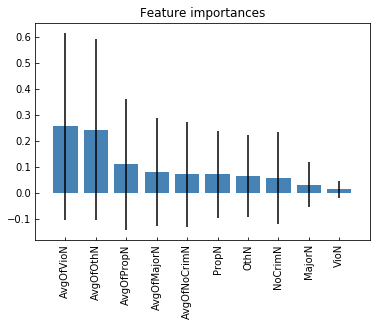

In [365]:
featureImportancePlot(rf_min_max, X_crime.columns)

#### Figure 10.2.2 Plot of Feature importance with errors. 
Note that the std is used as errors and shows how largely our features can vary.
It can be observed that NoCrimN has the greatest influence in our plot.
THree features are informative while the rest arenot. There is large dependencies amongst these variables.
Select: NoCrimN, AvgofVioN, and AvgOfOthN


# 11. Random forest with crime and medical (and income if you have it) features hints on modeling

## 11.1 create a random forest model that only uses the 3 most predictive features about school crimes and the health features (and income if you have it from the EC) (3 points)


In [366]:
colsq11 = ['SATall','NoCrim N','AvgOfOth N','AvgOfVio N']
cols_q11 = colsq11 + H_fs
cols_q11

['SATall', 'NoCrim N', 'AvgOfOth N', 'AvgOfVio N', 'asthmaRatio', 'drugsRatio']

In [367]:
cols_q11 = tuple(cols_q11)

In [368]:
q11_1_rfr = puma_sch_hosp_q5.loc[:,cols_q11]
q11_1_rfr.rename(columns = {'SATall':'Y','Major N':'MajorN',\
                           'Oth N':'OthN','NoCrim N':'NoCrimN',\
                           'Prop N':'PropN','Vio N':'VioN','AvgOfMajor N':'AvgOfMajorN',\
                           'AvgOfOth N':'AvgOfOthN','AvgOfNoCrim N':'AvgOfNoCrimN',\
                           'AvgOfProp N':'AvgOfPropN','AvgOfVio N':'AvgOfVioN'}, inplace=True)
q11_1_rfrcols = q11_1_rfr.drop('Y',axis=1).columns
q11_1_rfr.head(2)

,Y,NoCrimN,AvgOfOthN,AvgOfVioN,asthmaRatio,drugsRatio
0,374.740741,0.000,0.00000,0.00000,0.036503,0.063314
1,409.125000,1.625,0.41625,0.18875,0.037053,0.032269


In [369]:
X_crime_health = q11_1_rfr.loc[:,q11_1_rfrcols]
X_crime_health.tail(1)

,NoCrimN,AvgOfOthN,AvgOfVioN,asthmaRatio,drugsRatio
35,0.25,1.1875,0.55875,0.028861,0.094022


In [370]:
y = ravel(q11_1_rfr[['Y']])
y

array([374.74074074, 409.125     , 372.55855856, 356.83333333,
       364.11111111, 379.85964912, 378.0625    , 483.625     ,
       389.30952381, 393.69230769, 479.03333333, 464.66666667,
       428.83333333, 471.34722222, 428.        , 503.5       ,
       429.16666667, 381.91666667, 424.13043478, 406.61904762,
       368.53333333, 378.92592593, 377.96969697, 397.40740741,
       450.66666667, 395.83333333, 479.80952381, 392.28888889,
       456.66666667, 387.38095238, 401.59259259, 455.60714286,
       380.66666667, 469.        , 422.86666667, 432.375     ])

In [371]:
## Scale!!! 

In [372]:
# Standarizing::

In [373]:
q11_1_crimehealth_scaled = pd.DataFrame(columns=X_crime_health.columns, data=preprocessing.scale(X_crime_health))
q11_1_crimehealth_scaled.head()

,NoCrimN,AvgOfOthN,AvgOfVioN,asthmaRatio,drugsRatio
0,-0.794531,-0.810732,-0.869725,0.396053,0.240826
1,-0.334674,-0.565271,-0.592757,0.431142,-0.287559
2,0.207403,-0.538834,-0.558402,0.888153,2.616807
3,-0.794531,-0.810732,-0.869725,1.542707,-0.605590
4,-0.794531,-0.810732,-0.869725,1.705806,-0.774296


In [374]:
R2_train=[]
R2_test=[]
for i in range(50):
    X_train, X_test, y_train, y_test = train_test_split(q11_1_crimehealth_scaled, y, test_size=0.3)
    # Supervised transformation based on random forests
    rf_crime_health = rfr(max_depth=3, n_estimators=100, random_state=1)
    rf_crime_health.fit(X_train, y_train)
    y_pred = rf_crime_health.predict(X_test)
    R2_train.append(rf_crime_health.score(X_train, y_train))
    R2_test.append(rf_crime_health.score(X_test, y_test))

## 11.2 evaluate the performance of the model (3 points)

In [375]:
print("R2_train:",mean(R2_train),"\n R2_test",mean(R2_test))
print("R2 train std:",np.std(R2_train))

R2_train: 0.8855416564048407 
 R2_test 0.3473560718687041
R2 train std: 0.028089393831353435


** Comments on results: ** the model is not very satisfactory as train data perfroms better than test data, but at least we have positive correlations! i also tried min_max scaling method as it showed the best R2 results in question 10, but as mentioned this is not the preferred method become outliers are supressed. In this questions standarization works much better thn mix_max scaling as expected.

In [376]:
y_pred = rf_crime_health.predict(X_test)
zx_11 = skl.mean_squared_error(y_test, y_pred)
#pl.colorbar()
zx_11

962.5063023572628

In [377]:
print("Compared to other models in question 10, our mean standard error MSE changed from ",round(zx, 0),\
      "in not scaled model,",'%.2f'%zx_st,\
      "in standarized model and ",'%.2f'%zx_scaled,'in min-max model, to ','%.2f'%zx_11,\
      " in this question 11 with five features")

Compared to other models in question 10, our mean standard error MSE changed from  1037.0 in not scaled model, 925.84 in standarized model and  1648.83 in min-max model, to  962.51  in this question 11 with five features


after comparing the MSE, we observe that question 11 provides a much better model in every sense: 
in terms of R2 and MSE.

## 11.3 discuss the importance of each feature in the model (4 points)

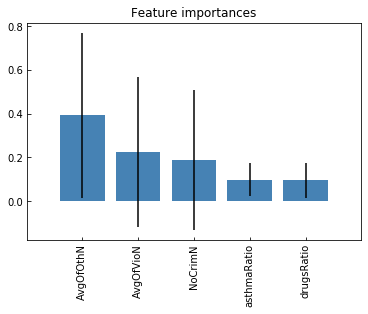

In [378]:
featureImportancePlot(rf_crime_health, X_crime_health.columns)

** Figure 11.3 ** It can be shown that "average of other crimes for all buildings that have the same EnGroupA/Range A" (AvfOFtheN) have a large importance on the SAT results.
Note that the std is used as errors and shows how largely our features can vary.
Compared to regression in q10, the importance increases for all the regressors as we have less features and there are not so many intercorrelated variables in our data.

Drugs ratio is not very correlated to correlation matrix before.

# FBB ok, you really cannot asserss the feature importance. the uncertainty (plotted is the 1-sigma uncertainty) in the feature importance indicated that all features are consistent with each other, i.e. you cannot tell from this model which is most important. Also they are consistent with 0, i.e. you an throw them away and the model is just fine. You cannot do feature importance with bad models. 

#### Further discussion: In order to further improve our model, the features should be as independent to each other as possible. We can try having the means of the correlated features like crime to combine them into a signle independent one. 

# Extra Credit

# Q5 EC

In [ ]:
from censusAPI import myAPI


In [ ]:
keyNBB = 'B19001_001E'
# Defined as '19001. Household Income' in ACS database

In [ ]:
#getting the first row of the table: the total number of households
url = "http://api.census.gov/data/2012/acs5?get="  + keyNBB +\
",NAME&for=public%20use%20microdata%20area:*&in=state:36&key=" + myAPI
resp = requests.request('GET', url).content
pumaPP = pd.read_csv(io.StringIO(resp.decode('utf-8').replace('[','').replace(']','')))

pumaPP.head()

In [ ]:
alldata.head(2)

In [ ]:
extra_credit = alldata.merge(pumaPP, left_on='puma',right_on='public use microdata area', how ='inner')

# FBB sugh great improvement! good job! surprisingly few people have mentioned the uncertainty in the feature importance, very good for that.
# 1 10/10
# 2 10/10
# 3 9/10
# 4 10/10
# 5 10/10
# 6 9/10
# 7 10/10
# 8 10/10
# 9 10/10
# 10 10/10
# 11 10/10

# FBB yay!
# total 100/100
